In [145]:
from sklearn.datasets import make_classification
from torch import nn, optim
from skorch import NeuralNetClassifier
import numpy  as np
# sys.path.append('./pyperch')
# from pyperch.neural.backprop_nn import BackpropModule
import matplotlib.pyplot as plt
import torch
import random
from ucimlrepo import fetch_ucirepo
from sklearn.metrics import accuracy_score, make_scorer, f1_score, confusion_matrix, log_loss

import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from pipelines import KMeans_pipeline, TSNE_pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import helpers
import importlib
import pipelines
import pipeline_helpers
import seaborn as sns
from scipy.stats import kurtosis
from notebook_helper import reload_notebook_cell, generate_seed



# Generate Data

In [146]:
from generate_data import get_and_preprocess_sdas_data, get_and_preprocess_raisin_data, y_label_encode, CATEGORY_COLUMNS_UCML
from sklearn.preprocessing import  LabelEncoder
reload_notebook_cell()

X_train_sdas, X_test_sdas, y_train_sdas, y_test_sdas = get_and_preprocess_sdas_data()
X_train_raisin, X_test_raisin, y_train_raisin, y_test_raisin = get_and_preprocess_raisin_data()

# Initialize and fit LabelEncoder
y_train_encoded_sdas, y_test_encoded_sdas, label_encoder_sdas = y_label_encode(y_train_sdas,y_test_sdas)
y_train_encode_raisin, y_test_encode_raisin, label_encoder_raisin = y_label_encode(y_train_raisin, y_test_raisin)
y_train_sdas.value_counts()

c:\Users\WarrenKushner\Documents\ML\A3\generate_data.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[(X["Marital Status"]  != 1) & (X["Marital Status"] != 2) & (X["Marital Status"] != 4)]["Marital Status"] = -1


Removed columns: ["encoding__Mother's qualification_18", "encoding__Mother's qualification_44", "encoding__Father's qualification_18", "encoding__Father's occupation_161"]
Number of features after removal: 200


Target  
Graduate    1791
Dropout     1105
Enrolled     643
Name: count, dtype: int64

### PCA + KMEANS 

Using best components from previous step

* Best number of components for SDAS dataset: 154
* Best number of components for Raisin dataset: 3

In [147]:
reload_notebook_cell()
best_n_components_pca_sdas = 154
best_n_components_pca_raisin = 3

# Fit PCA for SDAS dataset
pca_sdas_comp = pipelines.PCA_pipeline(X_train_sdas, list_of_categories=CATEGORY_COLUMNS_UCML, n_components=best_n_components_pca_sdas, random_state=42).fit_transform(X_train_sdas)
pca_raisin_comp = pipelines.PCA_pipeline(X_train_raisin, list_of_categories=[], n_components=best_n_components_pca_raisin, random_state=42).fit_transform(X_train_raisin)


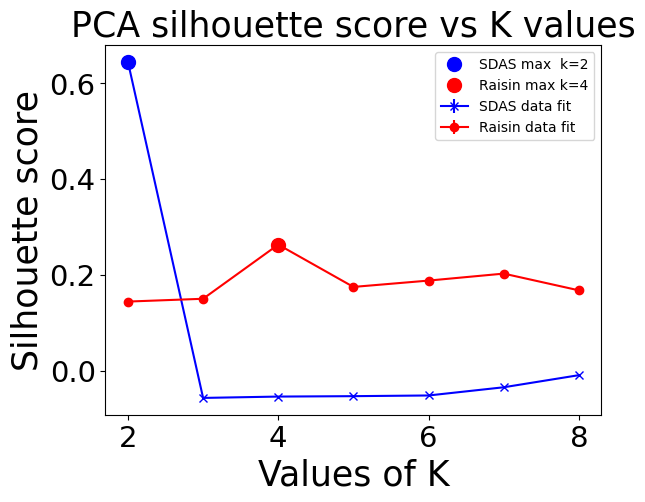

Max  silhouette score for SDAS data: 0.6447422682134616 at k=2
Max  silhouette score for Raisin data: 0.26364033564431827 at k=4


In [148]:
reload_notebook_cell()

range_n_clusters, \
mean_silhouette_sdas, \
std_silhouette_sdas, \
mean_silhouette_raisin, \
std_silhouette_raisin, \
max_mean_sdas_score, \
max_mean_sdas_k, \
max_mean_raisin_score, max_mean_raisin_k = pipeline_helpers.get_silhouette_scores((pca_sdas_comp, pca_raisin_comp),[], 42)

# Plot the mean and standard deviation
# Highlight the maximum mean silhouette score points

# Plot the mean and standard deviation
plt.errorbar(range_n_clusters, mean_silhouette_sdas, yerr=std_silhouette_sdas, fmt='bx-', label='SDAS data fit')
plt.errorbar(range_n_clusters, mean_silhouette_raisin, yerr=std_silhouette_raisin, fmt='ro-', label='Raisin data fit')
helpers.increase_font_size(plt)
# Highlight the maximum mean silhouette score points
max_mean_sdas_score = max(mean_silhouette_sdas)
max_mean_sdas_k = range_n_clusters[mean_silhouette_sdas.index(max_mean_sdas_score)]
plt.plot(max_mean_sdas_k, max_mean_sdas_score, "bo", markersize=10, label=f'SDAS max  k={max_mean_sdas_k}')

max_mean_raisin_score = max(mean_silhouette_raisin)
max_mean_raisin_k = range_n_clusters[mean_silhouette_raisin.index(max_mean_raisin_score)]
plt.plot(max_mean_raisin_k, max_mean_raisin_score, "ro", markersize=10, label=f'Raisin max k={max_mean_raisin_k}')

plt.xlabel("Values of K")
plt.ylabel("Silhouette score")
plt.title("PCA silhouette score vs K values")
helpers.increase_font_size_subplots_included(plt, title_fontsize=14, constant=1.8)
plt.legend()

plt.show()



print(f"Max  silhouette score for SDAS data: {max_mean_sdas_score} at k={max_mean_sdas_k}")
print(f"Max  silhouette score for Raisin data: {max_mean_raisin_score} at k={max_mean_raisin_k}")

# source https://www.analyticsvidhya.com/blog/2021/05/k-mean-getting-the-optimal-number-of-clusters/


In [149]:
# get the clusters for the optimimal k for sdas and raisin
kmeans_sdas = pipelines.KMeans_pipeline(pca_sdas_comp,n_clusters=max_mean_sdas_k, random_state=42).fit(pca_sdas_comp)
kmeans_raisin = pipelines.KMeans_pipeline(pca_raisin_comp,n_clusters=max_mean_raisin_k, random_state=42).fit(pca_raisin_comp)
kmeans_pca_labels_raisin = kmeans_raisin['classifier'].labels_
kmeans_pca_labels_sdas    = kmeans_sdas['classifier'].labels_

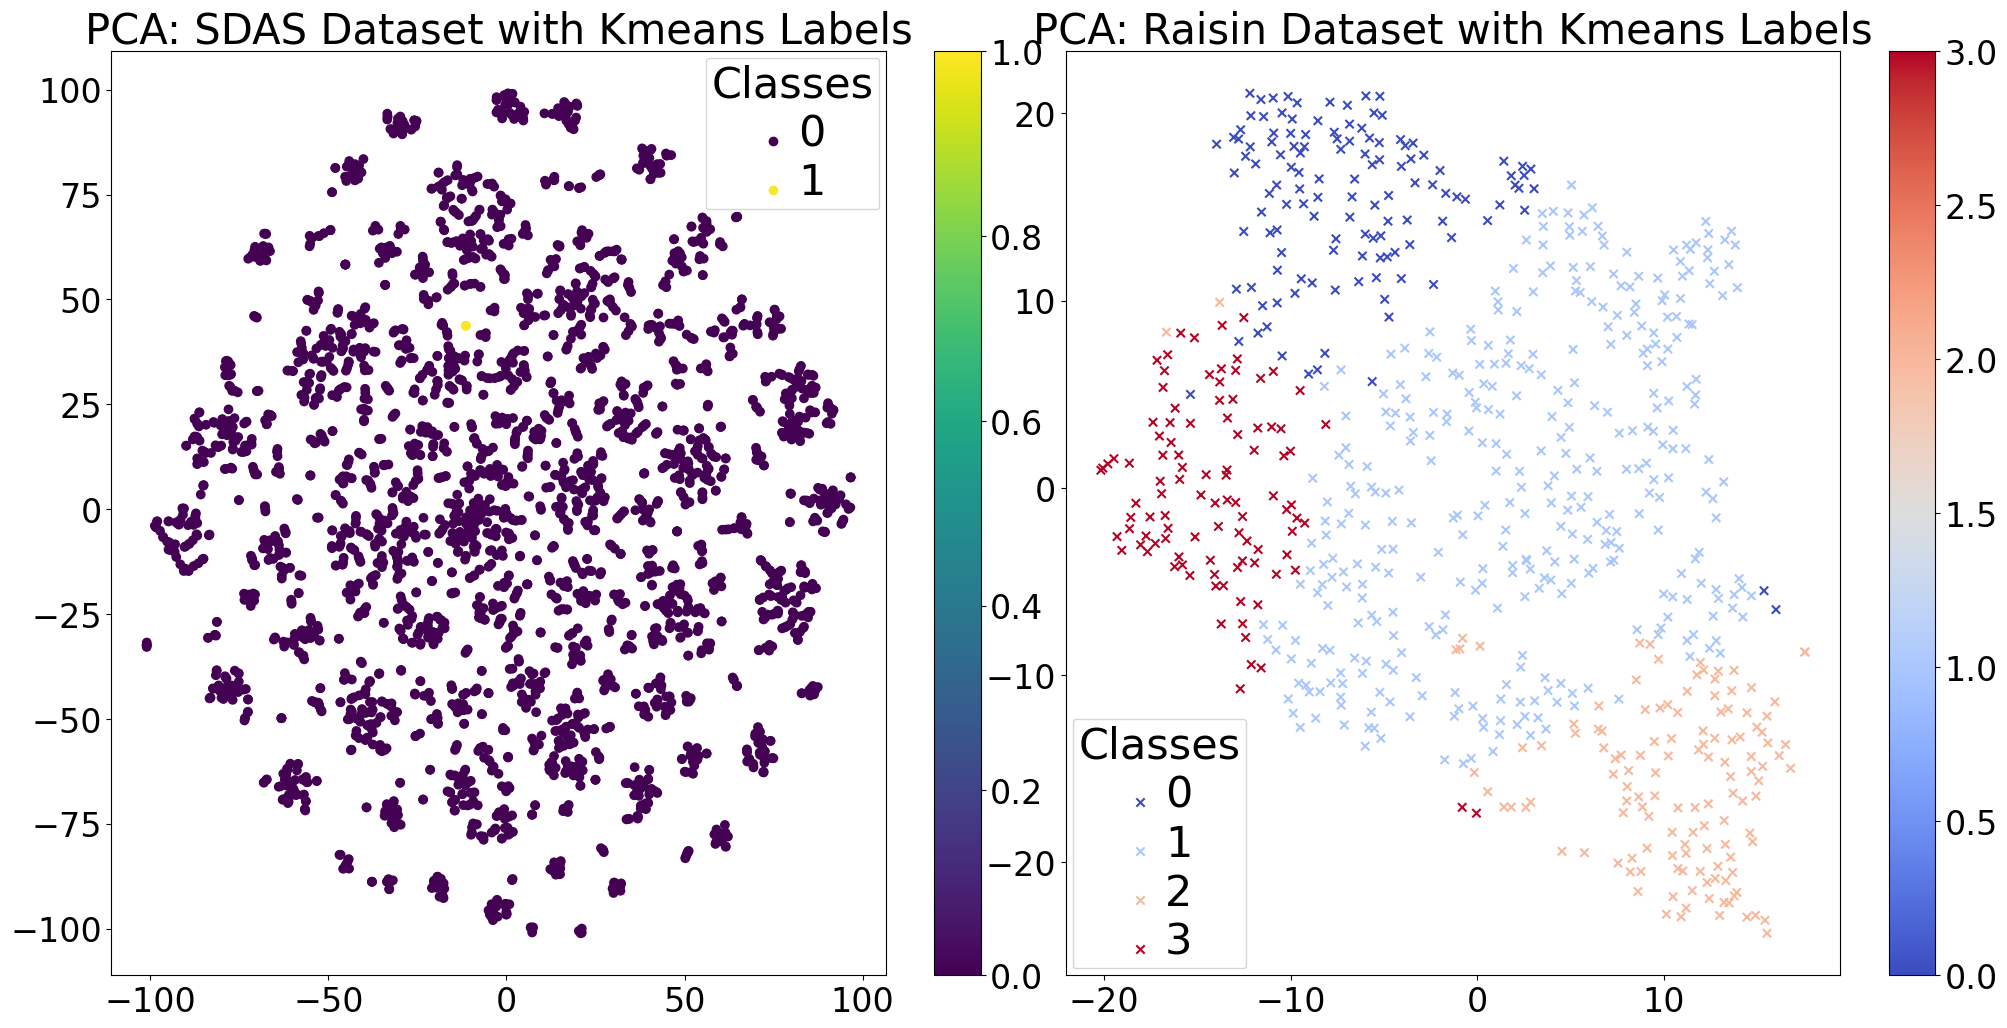

In [150]:
reload_notebook_cell()

kwargs_sdas_tsne = {'n_components': 2, 'random_state': 42, 'perplexity': 5}
kwargs_raisin_tsne = {'n_components': 2, 'random_state': 42, 'perplexity': 50}
tsne_sdas = TSNE_pipeline(pca_sdas_comp, list_of_categories=[], **kwargs_sdas_tsne)
tsne_raisin = TSNE_pipeline(pca_raisin_comp, **kwargs_raisin_tsne)
    
tsne_comps_raisin = tsne_raisin.fit_transform(pca_raisin_comp)
tsne_comps_asds = tsne_sdas.fit_transform(pca_sdas_comp)
    
# Create subplots for visualization
plt.figure(figsize=(20, 10))

# SDAS Dataset
plt.subplot(1, 2, 1)
plt.title("PCA: SDAS Dataset with Kmeans Labels")
scatter_sdas = plt.scatter(tsne_comps_asds[:, 0], tsne_comps_asds[:, 1], c=kmeans_pca_labels_sdas, cmap='viridis', marker='o', alpha=1)
plt.colorbar()
# Create a legend for SDAS dataset
handles_sdas, _ = scatter_sdas.legend_elements()
labels_sdas = [str(i) for i in np.unique(kmeans_pca_labels_sdas)]
plt.legend(handles_sdas, labels_sdas, title="Classes")
plt.tight_layout()

# Raisin Dataset
plt.subplot(1, 2, 2)
plt.title("PCA: Raisin Dataset with Kmeans Labels")
scatter_raisin = plt.scatter(tsne_comps_raisin[:, 0], tsne_comps_raisin[:, 1], c=kmeans_pca_labels_raisin, cmap='coolwarm', marker='x', alpha=1)
plt.colorbar()
# Create a legend for Raisin dataset
handles_raisin, _ = scatter_raisin.legend_elements()
labels_raisin = [str(i) for i in np.unique(kmeans_pca_labels_raisin)]
plt.legend(handles_raisin, labels_raisin, title="Classes")

plt.tight_layout()
helpers.increase_font_size_subplots_included(   plt, title_fontsize=15, constant=2)

plt.show()

In [151]:
import pandas as pd
reload_notebook_cell()

# Create a mapping from encoded labels to original labels
label_mapping_sdas = {i: label for i, label in enumerate(y_train_sdas['Target'].unique())}
label_mapping_raisin = {i: label for i, label in enumerate(y_train_raisin['Class'].unique())}

cluster_label_counts_table = pipeline_helpers.cluster_label_counts(y_train_sdas['Target'], kmeans_pca_labels_sdas, label_mapping_sdas)

# display cluster labels
cluster_labels_sdas = pd.DataFrame({"cluster_labels": kmeans_pca_labels_sdas})

cluster_labels_sdas

cluster_labels_sdas["cluster_labels"] = cluster_labels_sdas["cluster_labels"].apply(lambda x: "Graduate" if x else "Enrolled")


# Calculate precision and recall
precision_recall_df = pipeline_helpers.calculate_precision_recall(y_train_sdas, cluster_labels_sdas["cluster_labels"], label_mapping_sdas)
print(precision_recall_df)

# Map cluster labels to the original labels
cluster_labels_sdas = pd.DataFrame({"cluster_labels": kmeans_pca_labels_sdas})
cluster_labels_sdas["cluster_labels"] = cluster_labels_sdas["cluster_labels"].apply(lambda x: "Dropout" if x else "Graduate")
precision_recall_df = pipeline_helpers.calculate_precision_recall(y_train_sdas, cluster_labels_sdas["cluster_labels"], label_mapping_sdas)
print(precision_recall_df, "print not able to distinguish what label should belong to what class ")
cluster_label_counts_table

      Class  Precision    Recall
0   Dropout   0.000000  0.000000
1  Enrolled   0.181792  1.000000
2  Graduate   0.500000  0.000558
      Class  Precision    Recall
0   Dropout   0.500000  0.000905
1  Enrolled   0.000000  0.000000
2  Graduate   0.506079  0.999442 print not able to distinguish what label should belong to what class 


c:\Users\WarrenKushner\miniconda3\envs\MLA2\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\WarrenKushner\miniconda3\envs\MLA2\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\WarrenKushner\miniconda3\envs\MLA2\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\WarrenKushner\miniconda3\envs\MLA2\lib\site-packages\sklearn\metrics\_classi

True Labels     Dropout  Enrolled  Graduate
Cluster Labels                             
0                1104.0     643.0    1790.0
1                   1.0       0.0       1.0

In [152]:
reload_notebook_cell()

cluster_label_counts_table = pipeline_helpers.cluster_label_counts(y_train_raisin['Class'], kmeans_pca_labels_raisin, label_mapping_raisin)

# display cluster labels
cluster_labels_raisin = pd.DataFrame({"cluster_labels": kmeans_pca_labels_raisin})

cluster_labels_raisin["cluster_labels"] = cluster_labels_raisin["cluster_labels"].apply(lambda x: "Besni" if x in [0,3] else "Kecimen")


# Calculate precision and recall
precision_recall_df = pipeline_helpers.calculate_precision_recall(y_train_raisin, cluster_labels_raisin["cluster_labels"], label_mapping_raisin)
print(precision_recall_df)
cluster_label_counts_table

     Class  Precision    Recall
0    Besni   0.946903  0.587912
1  Kecimen   0.696356  0.966292


c:\Users\WarrenKushner\miniconda3\envs\MLA2\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


True Labels     Besni  Kecimen
Cluster Labels                
0                 124        2
1                 119      246
2                  31       98
3                  90       10

## RP + Kmeans


Using best components from previous step

* Best number of components for SDAS dataset: 186
* Best number of components for Raisin dataset: 5

In [184]:
# Fit PCA for SDAS dataset
best_n_components_rca_sdas = 186
best_n_components_rca_raisin = 5
rca_sdas_comp = pipelines.GaussianRP_pipeline(X_train_sdas, list_of_categories=CATEGORY_COLUMNS_UCML, n_components=best_n_components_rca_sdas, random_state=42).fit_transform(X_train_sdas)
rca_raisin_comp = pipelines.GaussianRP_pipeline(X_train_raisin, list_of_categories=[], n_components=best_n_components_rca_raisin, random_state=42).fit_transform(X_train_raisin)

Max  silhouette score for SDAS data: 0.6350337280863495 at k=2
Max  silhouette score for Raisin data: 0.37155338327124 at k=2


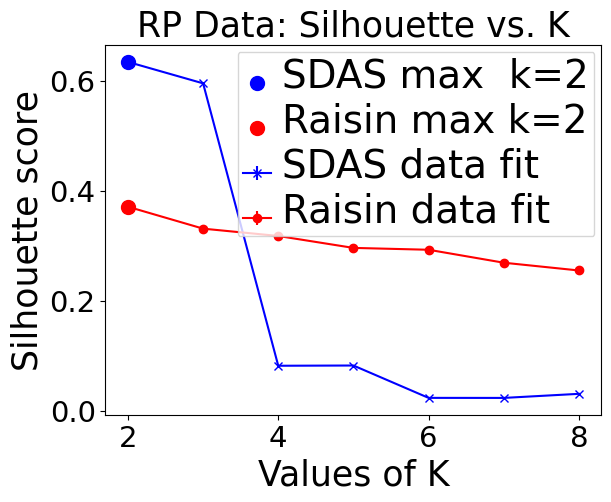

In [185]:
reload_notebook_cell()

range_n_clusters, \
mean_silhouette_sdas, \
std_silhouette_sdas, \
mean_silhouette_raisin, \
std_silhouette_raisin, \
max_mean_sdas_score, \
max_mean_sdas_k, \
max_mean_raisin_score, max_mean_raisin_k = pipeline_helpers.get_silhouette_scores((rca_sdas_comp, rca_raisin_comp),[], 42)

# Plot the mean and standard deviation
# Highlight the maximum mean silhouette score points

# Plot the mean and standard deviation
plt.errorbar(range_n_clusters, mean_silhouette_sdas, yerr=std_silhouette_sdas, fmt='bx-', label='SDAS data fit')
plt.errorbar(range_n_clusters, mean_silhouette_raisin, yerr=std_silhouette_raisin, fmt='ro-', label='Raisin data fit')
helpers.increase_font_size(plt)
# Highlight the maximum mean silhouette score points
max_mean_sdas_score = max(mean_silhouette_sdas)
max_mean_sdas_k = range_n_clusters[mean_silhouette_sdas.index(max_mean_sdas_score)]
plt.plot(max_mean_sdas_k, max_mean_sdas_score, "bo", markersize=10, label=f'SDAS max  k={max_mean_sdas_k}')

max_mean_raisin_score = max(mean_silhouette_raisin)
max_mean_raisin_k = range_n_clusters[mean_silhouette_raisin.index(max_mean_raisin_score)]
plt.plot(max_mean_raisin_k, max_mean_raisin_score, "ro", markersize=10, label=f'Raisin max k={max_mean_raisin_k}')

plt.xlabel("Values of K")
plt.ylabel("Silhouette score")
plt.title("RP Data: Silhouette vs. K")
plt.legend()
helpers.increase_font_size_subplots_included(plt, title_fontsize=14, constant=1.8)
print(f"Max  silhouette score for SDAS data: {max_mean_sdas_score} at k={max_mean_sdas_k}")
print(f"Max  silhouette score for Raisin data: {max_mean_raisin_score} at k={max_mean_raisin_k}")

In [186]:
reload_notebook_cell()
# get the clusters for the optimimal k for sdas and raisin
kmeans_sdas = pipelines.KMeans_pipeline(rca_sdas_comp,n_clusters=max_mean_sdas_k, random_state=42).fit(rca_sdas_comp)
kmeans_raisin = pipelines.KMeans_pipeline(rca_raisin_comp,n_clusters=max_mean_raisin_k, random_state=42).fit(rca_raisin_comp)
kmeans_pca_labels_raisin = kmeans_raisin['classifier'].labels_
kmeans_pca_labels_sdas    = kmeans_sdas['classifier'].labels_

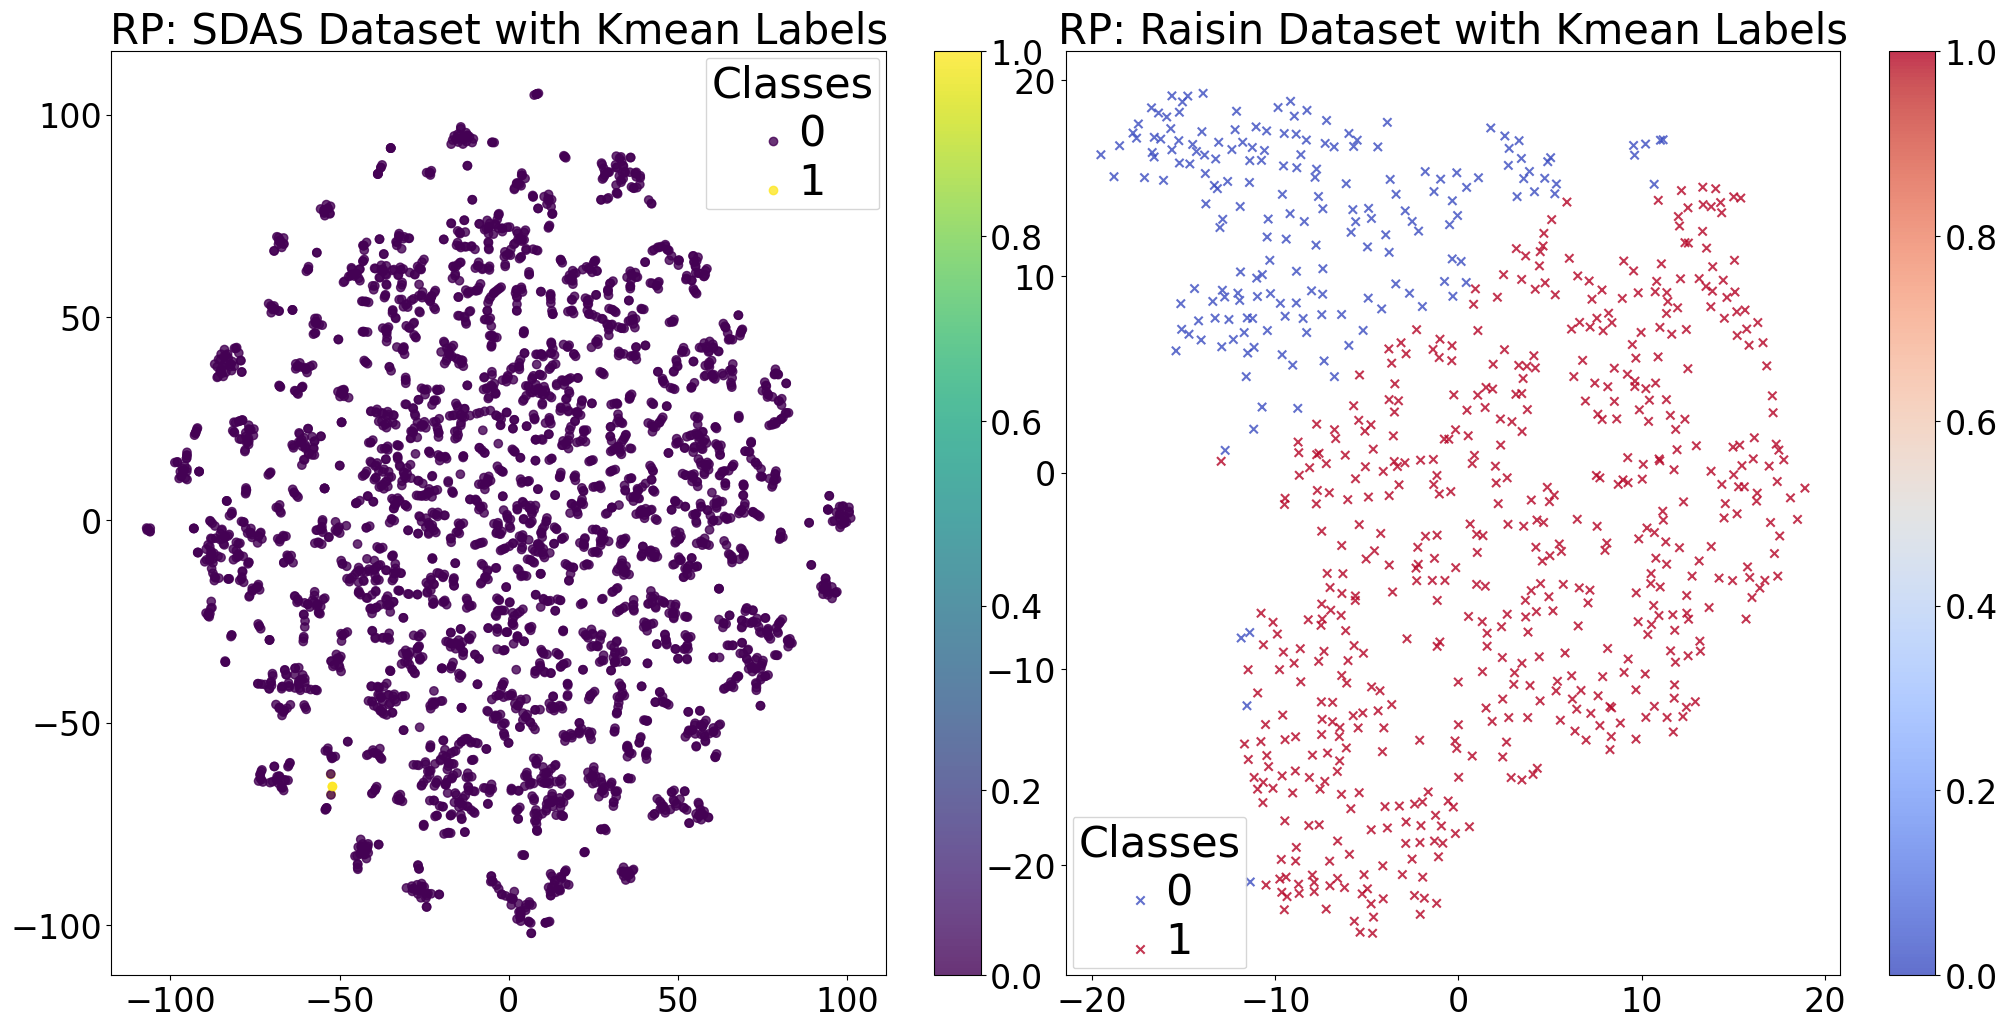

In [187]:
# Visualize clusters vs original labels using t-SNE
reload_notebook_cell()

kwargs_sdas_tsne = {'n_components': 2, 'random_state': 42, 'perplexity': 5}
kwargs_raisin_tsne = {'n_components': 2, 'random_state': 42, 'perplexity': 50}
tsne_sdas = TSNE_pipeline(rca_sdas_comp, list_of_categories=[], **kwargs_sdas_tsne)
tsne_raisin = TSNE_pipeline(rca_raisin_comp, **kwargs_raisin_tsne)
    
tsne_comps_raisin = tsne_raisin.fit_transform(rca_raisin_comp)
tsne_comps_asds = tsne_sdas.fit_transform(rca_sdas_comp)
    
# Create subplots for visualization
plt.figure(figsize=(20, 10))

# SDAS Dataset
plt.subplot(1, 2, 1)
plt.title("RP: SDAS Dataset with Kmean Labels")
scatter_sdas = plt.scatter(tsne_comps_asds[:, 0], tsne_comps_asds[:, 1], c=kmeans_pca_labels_sdas, cmap='viridis', marker='o', alpha=0.8)
plt.colorbar()
# Create a legend for SDAS dataset
handles_sdas, _ = scatter_sdas.legend_elements()
labels_sdas = [str(i) for i in np.unique(kmeans_pca_labels_sdas)]
plt.legend(handles_sdas, labels_sdas, title="Classes")
plt.tight_layout()

# Raisin Dataset
plt.subplot(1, 2, 2)
plt.title("RP: Raisin Dataset with Kmean Labels")
scatter_raisin = plt.scatter(tsne_comps_raisin[:, 0], tsne_comps_raisin[:, 1], c=kmeans_pca_labels_raisin, cmap='coolwarm', marker='x', alpha=0.8)
plt.colorbar()
# Create a legend for Raisin dataset
handles_raisin, _ = scatter_raisin.legend_elements()
labels_raisin = [str(i) for i in np.unique(kmeans_pca_labels_raisin)]
plt.legend(handles_raisin, labels_raisin, title="Classes")

plt.tight_layout()
# helpers.increase_font_size_subplots_included(plt, label_fontsize=16, title_fontsize=16*1.1, legend_fontsize=12*1.3, tick_fontsize=12*1.3, constant=1.6)
helpers.increase_font_size_subplots_included(   plt, title_fontsize=15, constant=2)
plt.show()

In [157]:
import pandas as pd
reload_notebook_cell()

# Create a mapping from encoded labels to original labels
label_mapping_sdas = {i: label for i, label in enumerate(y_train_sdas['Target'].unique())}
label_mapping_raisin = {i: label for i, label in enumerate(y_train_raisin['Class'].unique())}

cluster_label_counts_table = pipeline_helpers.cluster_label_counts(y_train_sdas['Target'], kmeans_pca_labels_sdas, label_mapping_sdas)

# display cluster labels
cluster_labels_sdas = pd.DataFrame({"cluster_labels": kmeans_pca_labels_sdas})

cluster_labels_sdas

cluster_labels_sdas["cluster_labels"] = cluster_labels_sdas["cluster_labels"].apply(lambda x: "Graduate" if x else "Enrolled")


# Calculate precision and recall
precision_recall_df = pipeline_helpers.calculate_precision_recall(y_train_sdas, cluster_labels_sdas["cluster_labels"], label_mapping_sdas)
print(precision_recall_df)

# Map cluster labels to the original labels
cluster_labels_sdas = pd.DataFrame({"cluster_labels": kmeans_pca_labels_sdas})
cluster_labels_sdas["cluster_labels"] = cluster_labels_sdas["cluster_labels"].apply(lambda x: "Dropout" if x else "Graduate")
precision_recall_df = pipeline_helpers.calculate_precision_recall(y_train_sdas, cluster_labels_sdas["cluster_labels"], label_mapping_sdas)
print(precision_recall_df, "print not able to distinguish what label should belong to what class ")
cluster_label_counts_table

      Class  Precision    Recall
0   Dropout   0.000000  0.000000
1  Enrolled   0.181895  1.000000
2  Graduate   0.750000  0.001675
      Class  Precision    Recall
0   Dropout   0.250000  0.000905
1  Enrolled   0.000000  0.000000
2  Graduate   0.505799  0.998325 print not able to distinguish what label should belong to what class 


c:\Users\WarrenKushner\miniconda3\envs\MLA2\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\WarrenKushner\miniconda3\envs\MLA2\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\WarrenKushner\miniconda3\envs\MLA2\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\WarrenKushner\miniconda3\envs\MLA2\lib\site-packages\sklearn\metrics\_classi

True Labels     Dropout  Enrolled  Graduate
Cluster Labels                             
0                1104.0     643.0    1788.0
1                   1.0       0.0       3.0

In [158]:
reload_notebook_cell()

cluster_label_counts_table = pipeline_helpers.cluster_label_counts(y_train_raisin['Class'], kmeans_pca_labels_raisin, label_mapping_raisin)

# display cluster labels
cluster_labels_raisin = pd.DataFrame({"cluster_labels": kmeans_pca_labels_raisin})

cluster_labels_raisin["cluster_labels"] = cluster_labels_raisin["cluster_labels"].apply(lambda x: "Besni" if x in [0,3] else "Kecimen")


# Calculate precision and recall
precision_recall_df = pipeline_helpers.calculate_precision_recall(y_train_raisin, cluster_labels_raisin["cluster_labels"], label_mapping_raisin)
print(precision_recall_df)
cluster_label_counts_table

     Class  Precision    Recall
0    Besni   0.967914  0.497253
1  Kecimen   0.656660  0.983146


c:\Users\WarrenKushner\miniconda3\envs\MLA2\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


True Labels     Besni  Kecimen
Cluster Labels                
0                 181        6
1                 183      350

## ICA + Kmeans


Using best components from previous step

* Best number of components for SDAS dataset: 6
* Best number of components for Raisin dataset: 2

* Best perplexity SDAS: 50
* Best perplexity Raisin: 50

In [159]:
# Fit PCA for SDAS dataset
ica_sdas_comp = pipelines.ICA_pipeline(X_train_sdas, list_of_categories=CATEGORY_COLUMNS_UCML, n_components=6, random_state=42).fit_transform(X_train_sdas)
ica_raisin_comp = pipelines.ICA_pipeline(X_train_raisin, list_of_categories=[], n_components=2, random_state=42).fit_transform(X_train_raisin)

Max  silhouette score for SDAS data: 0.3689858590345489 at k=4
Max  silhouette score for Raisin data: 0.885563453246691 at k=2


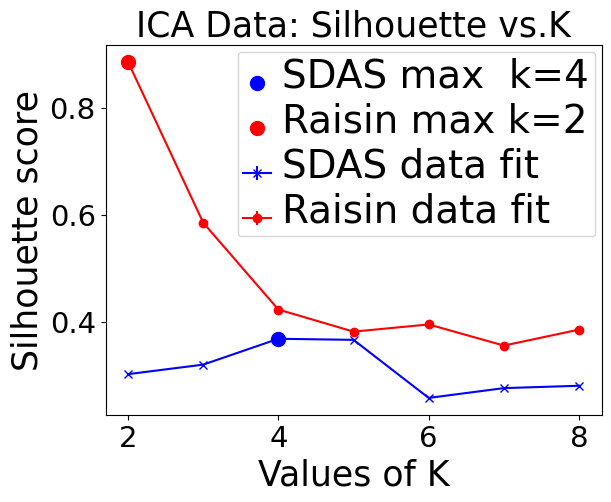

In [160]:
reload_notebook_cell()

range_n_clusters, \
mean_silhouette_sdas, \
std_silhouette_sdas, \
mean_silhouette_raisin, \
std_silhouette_raisin, \
max_mean_sdas_score, \
max_mean_sdas_k, \
max_mean_raisin_score, max_mean_raisin_k = pipeline_helpers.get_silhouette_scores((ica_sdas_comp, ica_raisin_comp),[], 42)

# Plot the mean and standard deviation
# Highlight the maximum mean silhouette score points

# Plot the mean and standard deviation
plt.errorbar(range_n_clusters, mean_silhouette_sdas, yerr=std_silhouette_sdas, fmt='bx-', label='SDAS data fit')
plt.errorbar(range_n_clusters, mean_silhouette_raisin, yerr=std_silhouette_raisin, fmt='ro-', label='Raisin data fit')
helpers.increase_font_size(plt)
# Highlight the maximum mean silhouette score points
max_mean_sdas_score = max(mean_silhouette_sdas)
max_mean_sdas_k = range_n_clusters[mean_silhouette_sdas.index(max_mean_sdas_score)]
plt.plot(max_mean_sdas_k, max_mean_sdas_score, "bo", markersize=10, label=f'SDAS max  k={max_mean_sdas_k}')

max_mean_raisin_score = max(mean_silhouette_raisin)
max_mean_raisin_k = range_n_clusters[mean_silhouette_raisin.index(max_mean_raisin_score)]
plt.plot(max_mean_raisin_k, max_mean_raisin_score, "ro", markersize=10, label=f'Raisin max k={max_mean_raisin_k}')

plt.xlabel("Values of K")
plt.ylabel("Silhouette score")
plt.title("ICA Data: Silhouette vs.K")
plt.legend()
helpers.increase_font_size_subplots_included(plt, title_fontsize=14, constant=1.8)
print(f"Max  silhouette score for SDAS data: {max_mean_sdas_score} at k={max_mean_sdas_k}")
print(f"Max  silhouette score for Raisin data: {max_mean_raisin_score} at k={max_mean_raisin_k}")

In [161]:
kmeans_sdas = pipelines.KMeans_pipeline(ica_sdas_comp,n_clusters=max_mean_sdas_k, random_state=42).fit(rca_sdas_comp)
kmeans_raisin = pipelines.KMeans_pipeline(ica_raisin_comp,n_clusters=max_mean_raisin_k, random_state=42).fit(rca_raisin_comp)
kmeans_ica_labels_raisin = kmeans_raisin['classifier'].labels_
kmeans_ica_labels_sdas    = kmeans_sdas['classifier'].labels_

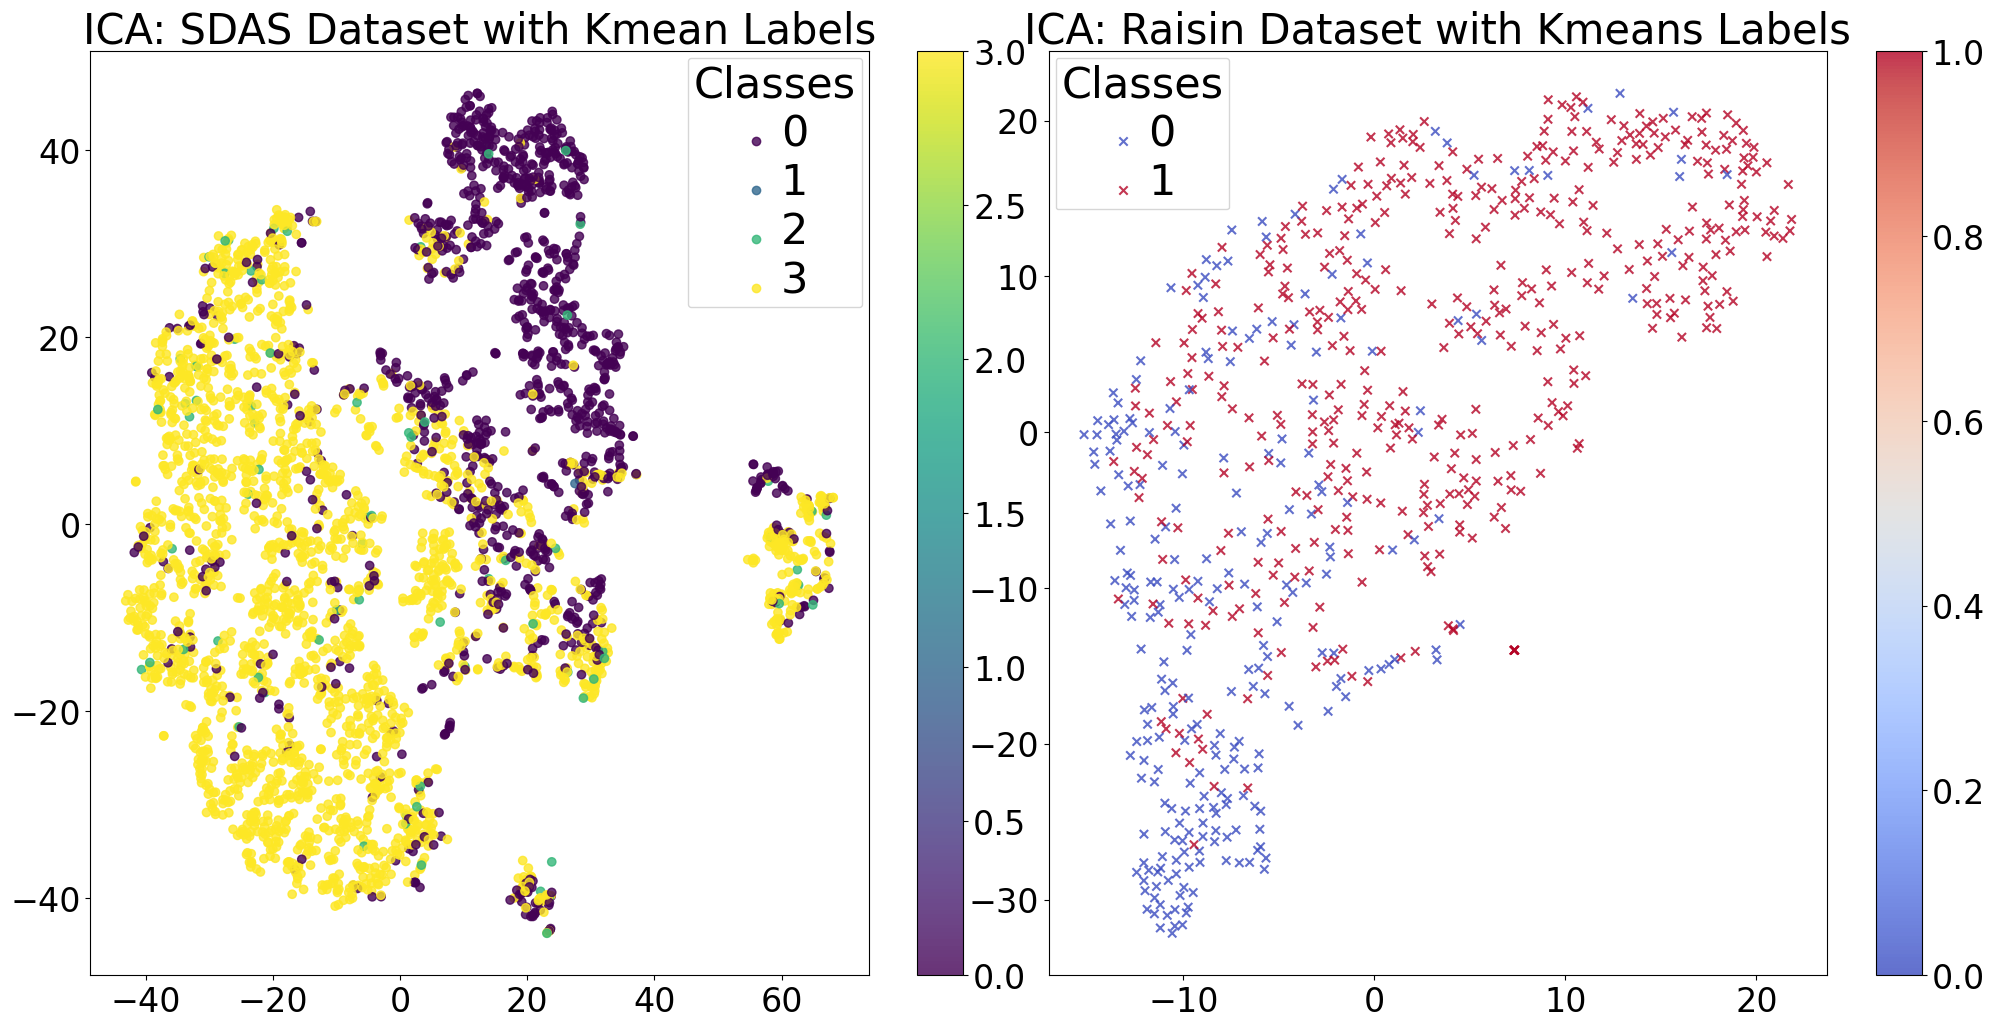

In [162]:
reload_notebook_cell()

# Visualize clusters vs original labels using t-SNE

kwargs_sdas_tsne = {'n_components': 2, 'random_state': 42, 'perplexity': 50}
kwargs_raisin_tsne = {'n_components': 2, 'random_state': 42, 'perplexity': 50}
tsne_sdas = TSNE_pipeline(ica_sdas_comp, list_of_categories=CATEGORY_COLUMNS_UCML, **kwargs_sdas_tsne)
tsne_raisin = TSNE_pipeline(ica_raisin_comp, **kwargs_raisin_tsne)
    
tsne_comps_raisin = tsne_raisin.fit_transform(ica_raisin_comp)
tsne_comps_asds = tsne_sdas.fit_transform(ica_sdas_comp)
    
# Create subplots for visualization
plt.figure(figsize=(20, 10))

# SDAS Dataset
plt.subplot(1, 2, 1)
plt.title("ICA: SDAS Dataset with Kmean Labels")
scatter_sdas = plt.scatter(tsne_comps_asds[:, 0], tsne_comps_asds[:, 1], c=kmeans_ica_labels_sdas, cmap='viridis', marker='o', alpha=0.8)
plt.colorbar()
# Create a legend for SDAS dataset
handles_sdas, _ = scatter_sdas.legend_elements()
labels_sdas = [str(i) for i in np.unique(kmeans_ica_labels_sdas)]
plt.legend(handles_sdas, labels_sdas, title="Classes")
plt.tight_layout()

# Raisin Dataset
plt.subplot(1, 2, 2)
plt.title("ICA: Raisin Dataset with Kmeans Labels")
scatter_raisin = plt.scatter(tsne_comps_raisin[:, 0], tsne_comps_raisin[:, 1], c=kmeans_ica_labels_raisin, cmap='coolwarm', marker='x', alpha=0.8)
plt.colorbar()
# Create a legend for Raisin dataset
handles_raisin, _ = scatter_raisin.legend_elements()
labels_raisin = [str(i) for i in np.unique(kmeans_ica_labels_raisin)]
plt.legend(handles_raisin, labels_raisin, title="Classes")

plt.tight_layout()
helpers.increase_font_size_subplots_included(   plt, title_fontsize=15, constant=2)
plt.show()

In [163]:
import pandas as pd
reload_notebook_cell()

# Create a mapping from encoded labels to original labels
label_mapping_sdas = {i: label for i, label in enumerate(y_train_sdas['Target'].unique())}
label_mapping_raisin = {i: label for i, label in enumerate(y_train_raisin['Class'].unique())}

cluster_label_counts_table = pipeline_helpers.cluster_label_counts(y_train_sdas['Target'], kmeans_ica_labels_sdas, label_mapping_sdas)

# display cluster labels
cluster_labels_sdas = pd.DataFrame({"cluster_labels": kmeans_ica_labels_sdas})

cluster_labels_sdas

cluster_labels_sdas["cluster_labels"] = cluster_labels_sdas["cluster_labels"].apply(lambda x: "Graduate" if x else "Enrolled")


# Calculate precision and recall
precision_recall_df = pipeline_helpers.calculate_precision_recall(y_train_sdas, cluster_labels_sdas["cluster_labels"], label_mapping_sdas)
print(precision_recall_df)

# Map cluster labels to the original labels
cluster_labels_sdas = pd.DataFrame({"cluster_labels": kmeans_ica_labels_sdas})
cluster_labels_sdas["cluster_labels"] = cluster_labels_sdas["cluster_labels"].apply(lambda x: "Dropout" if x else "Graduate")
precision_recall_df = pipeline_helpers.calculate_precision_recall(y_train_sdas, cluster_labels_sdas["cluster_labels"], label_mapping_sdas)
print(precision_recall_df, "print not able to distinguish what label should belong to what class ")
cluster_label_counts_table

      Class  Precision    Recall
0   Dropout   0.000000  0.000000
1  Enrolled   0.152827  0.269051
2  Graduate   0.646863  0.869347
      Class  Precision    Recall
0   Dropout   0.157873  0.343891
1  Enrolled   0.000000  0.000000
2  Graduate   0.206714  0.130653 print not able to distinguish what label should belong to what class 


c:\Users\WarrenKushner\miniconda3\envs\MLA2\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\WarrenKushner\miniconda3\envs\MLA2\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\WarrenKushner\miniconda3\envs\MLA2\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\WarrenKushner\miniconda3\envs\MLA2\lib\site-packages\sklearn\metrics\_classi

True Labels     Dropout  Enrolled  Graduate
Cluster Labels                             
0                 725.0     173.0     234.0
1                   0.0       0.0       1.0
2                   9.0      31.0      34.0
3                 371.0     439.0    1522.0

In [164]:
reload_notebook_cell()

cluster_label_counts_table = pipeline_helpers.cluster_label_counts(y_train_raisin['Class'], kmeans_ica_labels_raisin, label_mapping_raisin)

# display cluster labels
cluster_labels_raisin = pd.DataFrame({"cluster_labels": kmeans_ica_labels_raisin})

cluster_labels_raisin["cluster_labels"] = cluster_labels_raisin["cluster_labels"].apply(lambda x: "Besni" if x in [0,3] else "Kecimen")


# Calculate precision and recall
precision_recall_df = pipeline_helpers.calculate_precision_recall(y_train_raisin, cluster_labels_raisin["cluster_labels"], label_mapping_raisin)
print(precision_recall_df)
cluster_label_counts_table

     Class  Precision    Recall
0    Besni   0.687747  0.478022
1  Kecimen   0.593148  0.778090


c:\Users\WarrenKushner\miniconda3\envs\MLA2\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


True Labels     Besni  Kecimen
Cluster Labels                
0                 174       79
1                 190      277

## PCA + EM

In [165]:
reload_notebook_cell()
best_n_components_pca_sdas = 154
best_n_components_pca_raisin = 3

# Fit PCA for SDAS dataset
pca_sdas_comp = pipelines.PCA_pipeline(X_train_sdas, list_of_categories=CATEGORY_COLUMNS_UCML, n_components=best_n_components_pca_sdas, random_state=42).fit_transform(X_train_sdas)
pca_raisin_comp = pipelines.PCA_pipeline(X_train_raisin, list_of_categories=[], n_components=best_n_components_pca_raisin, random_state=42).fit_transform(X_train_raisin)

Best parameters for SDAS: {'classifier__covariance_type': 'diag', 'classifier__n_components': 6}
Min BIC score for SDAS: 232864.0046476541
Best parameters for Raisin: {'classifier__covariance_type': 'spherical', 'classifier__n_components': 2}
Min BIC score for Raisin: 1233.3290175502311


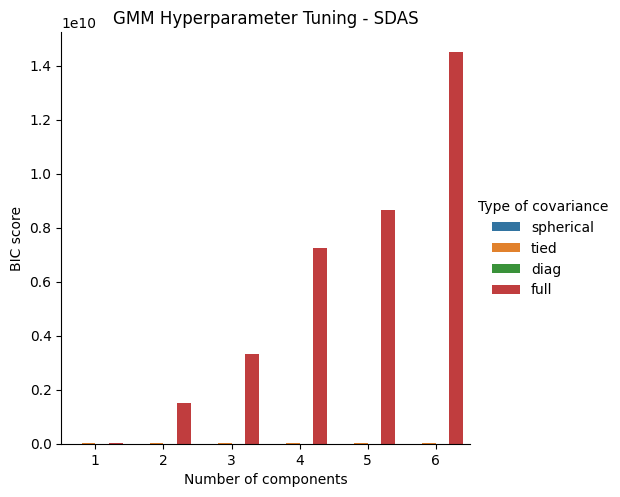

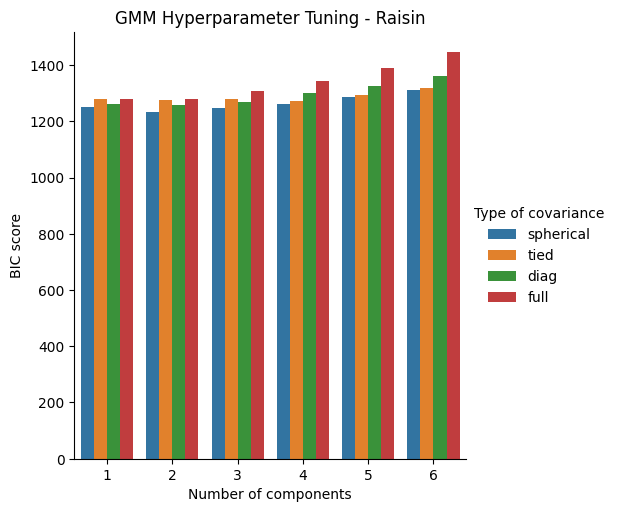

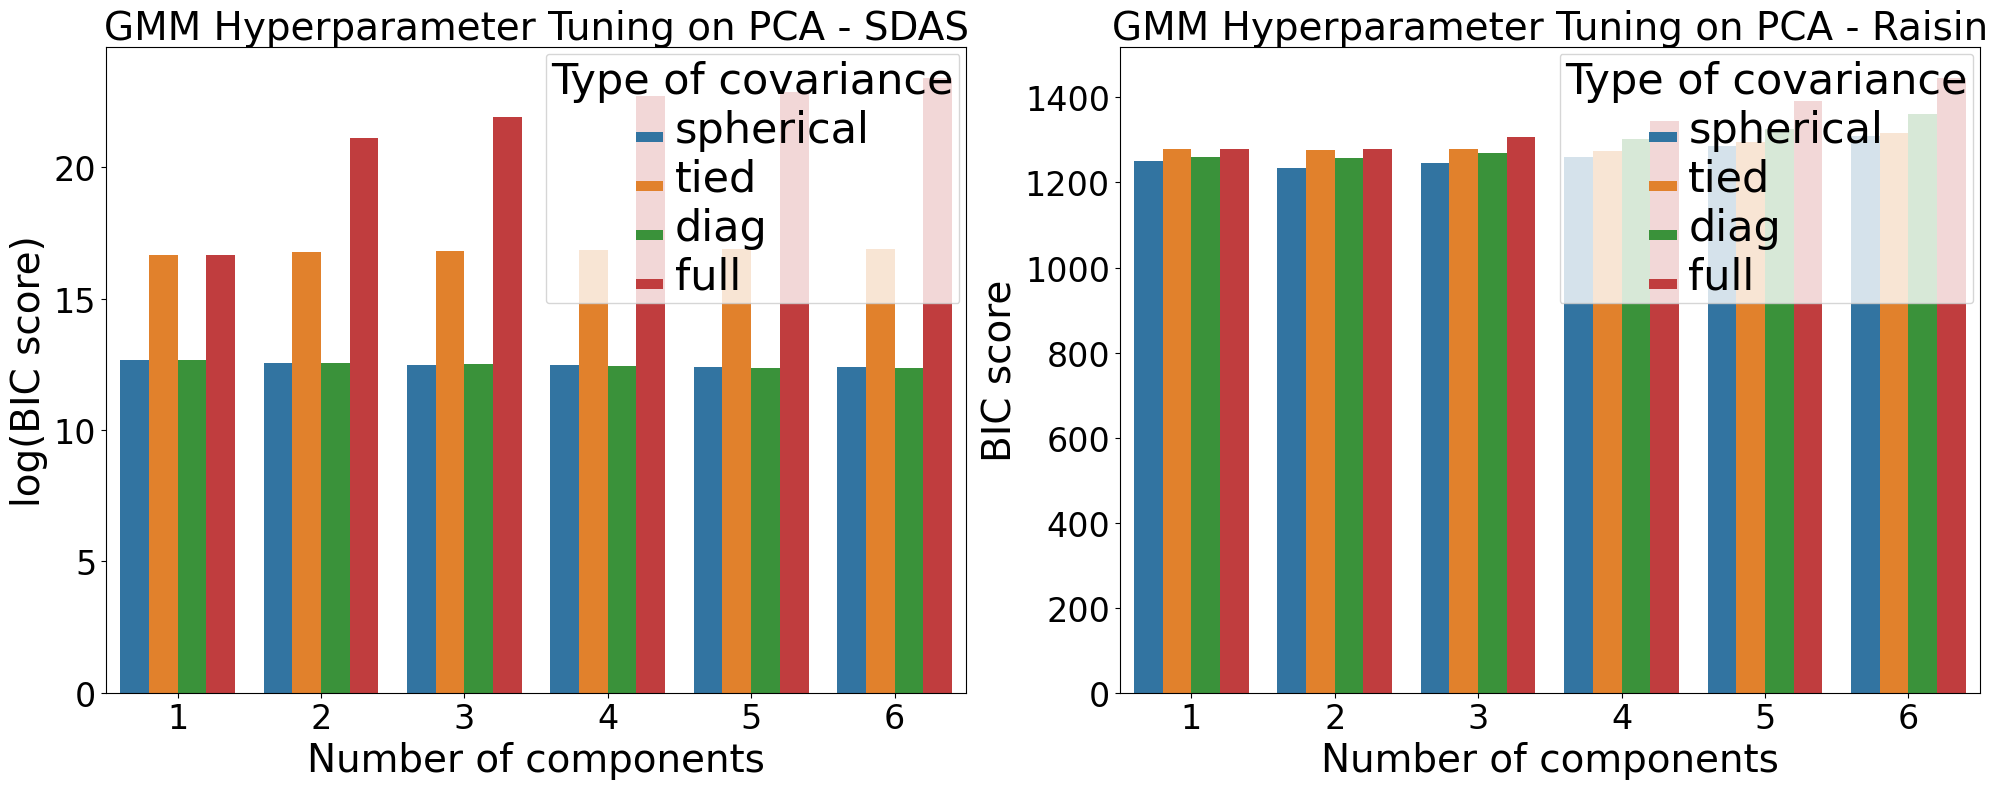

Best parameters for SDAS: {'classifier__covariance_type': 'diag', 'classifier__n_components': 6}
Min BIC score for SDAS: 232864.0046476541
Best parameters for Raisin: {'classifier__covariance_type': 'spherical', 'classifier__n_components': 2}
Min BIC score for Raisin: 1233.3290175502311


In [166]:
reload_notebook_cell()



# Perform GridSearchCV for both datasets
min_mean_sdas_bic, best_params_sdas, df_sdas = pipeline_helpers.grid_search_gmm(pca_sdas_comp, CATEGORY_COLUMNS_UCML, "SDAS")
min_mean_raisin_bic, best_params_raisin, df_raisin = pipeline_helpers.grid_search_gmm(pca_raisin_comp, [], "Raisin")

# Print the best parameters
print(f"Best parameters for SDAS: {best_params_sdas}")
print(f"Min BIC score for SDAS: {min_mean_sdas_bic}")
print(f"Best parameters for Raisin: {best_params_raisin}")
print(f"Min BIC score for Raisin: {min_mean_raisin_bic}")

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

df_sdas["log(BIC score)"] = np.log(df_sdas["BIC score"])
df_raisin["log(BIC score)"] = np.log(df_sdas["BIC score"])

# Plot SDAS results
sns.barplot(
    data=df_sdas,
    x="Number of components",
    y="log(BIC score)", # set scale to log so you can see the differences of spherical better
    hue="Type of covariance",
    ax=axs[0]
).set(title='GMM Hyperparameter Tuning on PCA - SDAS')

# Plot Raisin results
sns.barplot(
    data=df_raisin,
    x="Number of components",
    y="BIC score",
    hue="Type of covariance",
    ax=axs[1]
).set(title='GMM Hyperparameter Tuning on PCA - Raisin')
helpers.increase_font_size(plt)
helpers.increase_font_size_subplots_included(   plt, title_fontsize=14, constant=2)
# helpers.increase_font_size(axs[1])

# Adjust layout
plt.tight_layout()
plt.show()

# Print the best parameters and BIC scores
print(f"Best parameters for SDAS: {best_params_sdas}")
print(f"Min BIC score for SDAS: {min_mean_sdas_bic}")
print(f"Best parameters for Raisin: {best_params_raisin}")
print(f"Min BIC score for Raisin: {min_mean_raisin_bic}")

In [167]:
reload_notebook_cell()
## train the best model for SDAS and Raisin
# Fit GMM for SDAS dataset
best_gmm_sdas = pipelines.GMM_pipeline(pca_sdas_comp, CATEGORY_COLUMNS_UCML, n_components=best_params_sdas['classifier__n_components'], covariance_type=best_params_sdas['classifier__covariance_type'], random_state=42).fit(pca_sdas_comp)
best_gmm_raisin = pipelines.GMM_pipeline(pca_raisin_comp, [], n_components=best_params_raisin['classifier__n_components'], covariance_type=best_params_raisin['classifier__covariance_type'], random_state=42).fit(pca_raisin_comp)

# get the labels for the best model
gmm_labels_sdas_labels = best_gmm_sdas['classifier'].predict(pca_sdas_comp)
gmm_labels_raisin_labels = best_gmm_raisin['classifier'].predict(pca_raisin_comp)

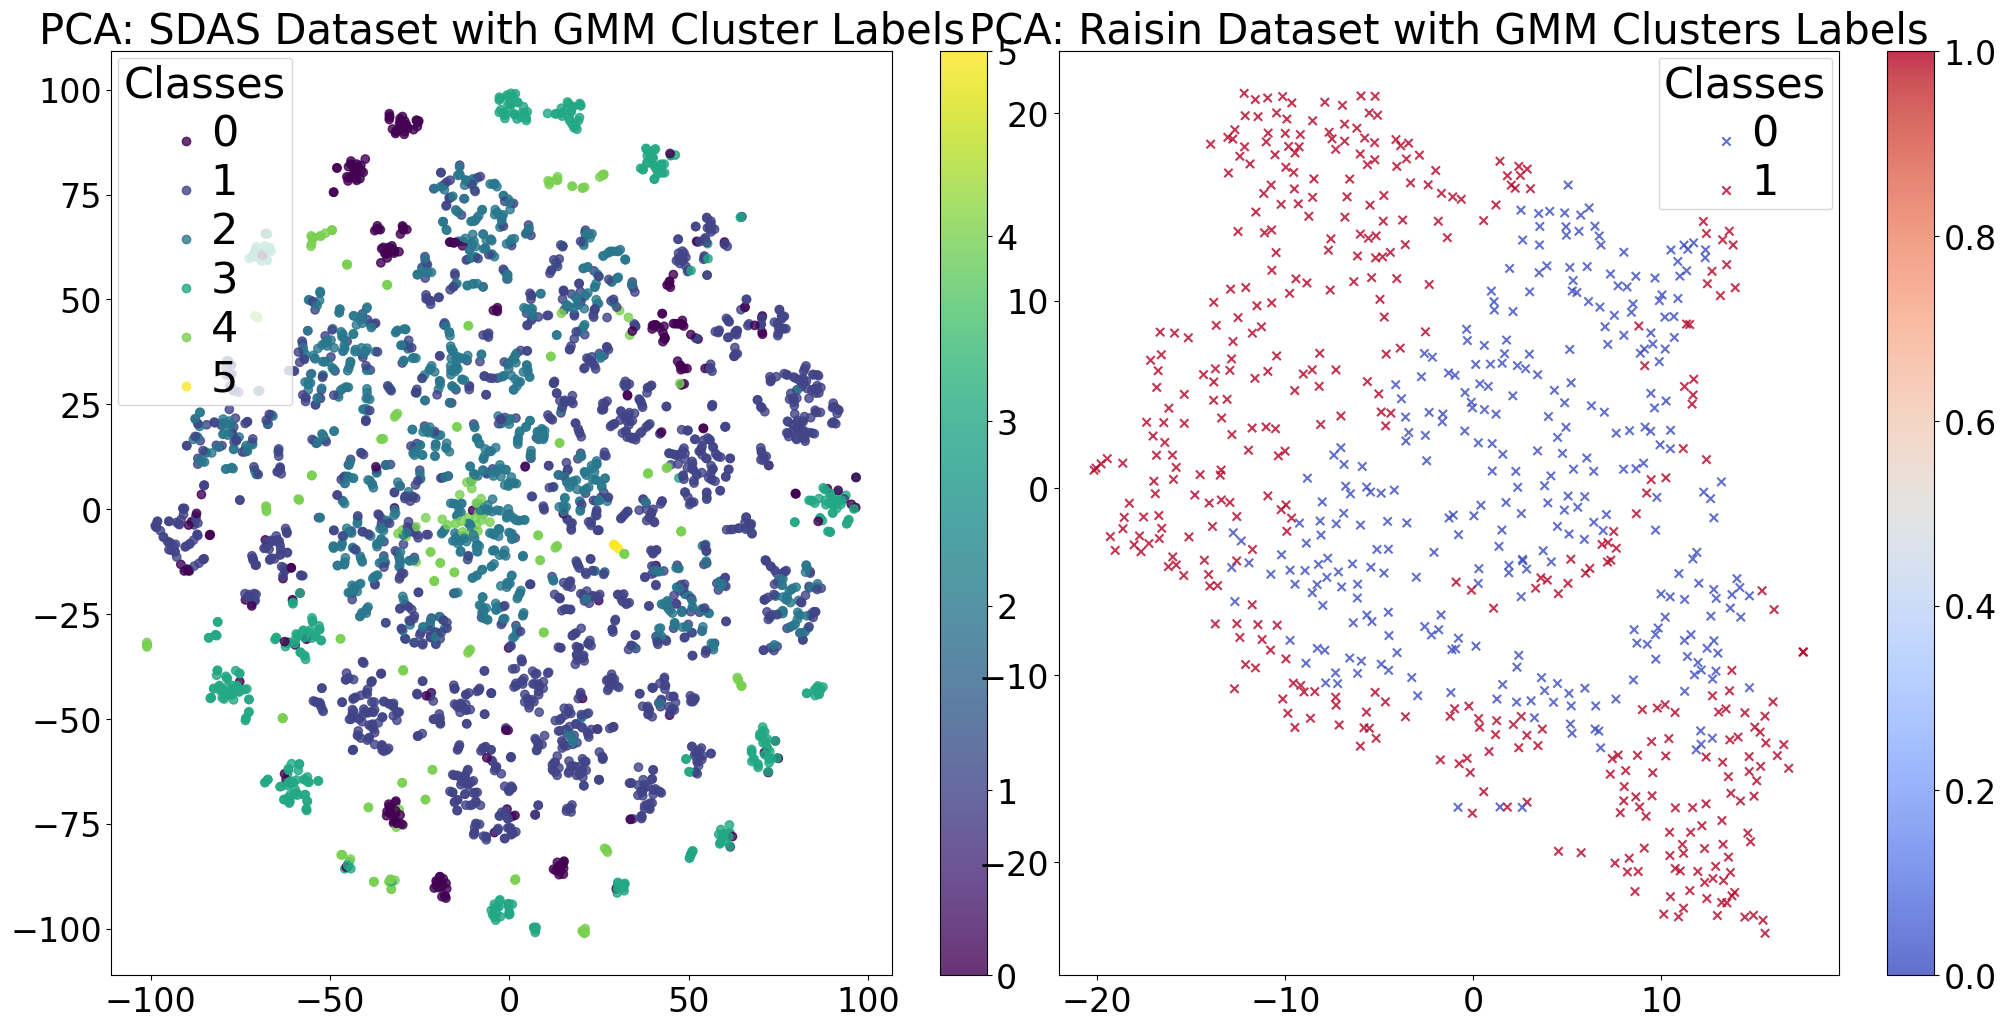

In [168]:
reload_notebook_cell()
# Visualize clusters vs original labels using t-SNE

kwargs_sdas_tsne = {'n_components': 2, 'random_state': 42, 'perplexity': 5}
kwargs_raisin_tsne = {'n_components': 2, 'random_state': 42, 'perplexity': 50}
tsne_sdas = TSNE_pipeline(pca_sdas_comp, list_of_categories=CATEGORY_COLUMNS_UCML, **kwargs_sdas_tsne)
tsne_raisin = TSNE_pipeline(pca_raisin_comp, **kwargs_raisin_tsne)
    
tsne_comps_raisin = tsne_raisin.fit_transform(pca_raisin_comp)
tsne_comps_asds = tsne_sdas.fit_transform(pca_sdas_comp)
    
# Create subplots for visualization
plt.figure(figsize=(20, 10))

# SDAS Dataset
plt.subplot(1, 2, 1)
plt.title("PCA: SDAS Dataset with GMM Cluster Labels")
scatter_sdas = plt.scatter(tsne_comps_asds[:, 0], tsne_comps_asds[:, 1], c=gmm_labels_sdas_labels, cmap='viridis', marker='o', alpha=0.8)
plt.colorbar()
# Create a legend for SDAS dataset
handles_sdas, _ = scatter_sdas.legend_elements()
labels_sdas = [str(i) for i in np.unique(gmm_labels_sdas_labels)]
plt.legend(handles_sdas, labels_sdas, title="Classes")
plt.tight_layout()

# Raisin Dataset
plt.subplot(1, 2, 2)
plt.title("PCA: Raisin Dataset with GMM Clusters Labels")
scatter_raisin = plt.scatter(tsne_comps_raisin[:, 0], tsne_comps_raisin[:, 1], c=gmm_labels_raisin_labels, cmap='coolwarm', marker='x', alpha=0.8)
plt.colorbar()
# Create a legend for Raisin dataset
handles_raisin, _ = scatter_raisin.legend_elements()
labels_raisin = [str(i) for i in np.unique(gmm_labels_raisin_labels)]
plt.legend(handles_raisin, labels_raisin, title="Classes")

plt.tight_layout()
helpers.increase_font_size_subplots_included(   plt, title_fontsize=15, constant=2)
plt.show()

In [169]:
import pandas as pd
reload_notebook_cell()

# Create a mapping from encoded labels to original labels
label_mapping_sdas = {i: label for i, label in enumerate(y_train_sdas['Target'].unique())}
label_mapping_raisin = {i: label for i, label in enumerate(y_train_raisin['Class'].unique())}

cluster_label_counts_table = pipeline_helpers.cluster_label_counts(y_train_sdas['Target'], gmm_labels_sdas_labels, label_mapping_sdas)

# display cluster labels
cluster_labels_sdas = pd.DataFrame({"cluster_labels": gmm_labels_sdas_labels})

cluster_labels_sdas

cluster_labels_sdas["cluster_labels"] = cluster_labels_sdas["cluster_labels"].apply(lambda x: "Graduate" if x else "Enrolled")


# Calculate precision and recall
precision_recall_df = pipeline_helpers.calculate_precision_recall(y_train_sdas, cluster_labels_sdas["cluster_labels"], label_mapping_sdas)
print(precision_recall_df)

# Map cluster labels to the original labels
cluster_labels_sdas = pd.DataFrame({"cluster_labels": kmeans_ica_labels_sdas})
cluster_labels_sdas["cluster_labels"] = cluster_labels_sdas["cluster_labels"].apply(lambda x: "Dropout" if x else "Graduate")
precision_recall_df = pipeline_helpers.calculate_precision_recall(y_train_sdas, cluster_labels_sdas["cluster_labels"], label_mapping_sdas)
print(precision_recall_df, "print not able to distinguish what label should belong to what class ")
cluster_label_counts_table

      Class  Precision    Recall
0   Dropout   0.000000  0.000000
1  Enrolled   0.162963  0.068429
2  Graduate   0.511471  0.933557
      Class  Precision    Recall
0   Dropout   0.157873  0.343891
1  Enrolled   0.000000  0.000000
2  Graduate   0.206714  0.130653 print not able to distinguish what label should belong to what class 


c:\Users\WarrenKushner\miniconda3\envs\MLA2\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\WarrenKushner\miniconda3\envs\MLA2\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\WarrenKushner\miniconda3\envs\MLA2\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\WarrenKushner\miniconda3\envs\MLA2\lib\site-packages\sklearn\metrics\_classi

True Labels     Dropout  Enrolled  Graduate
Cluster Labels                             
0                 107.0      44.0     119.0
1                 685.0     283.0     665.0
2                 111.0     177.0     734.0
3                 136.0      94.0     180.0
4                  64.0      45.0      91.0
5                   2.0       0.0       2.0

In [170]:
reload_notebook_cell()

cluster_label_counts_table = pipeline_helpers.cluster_label_counts(y_train_raisin['Class'], gmm_labels_raisin_labels, label_mapping_raisin)

# display cluster labels
cluster_labels_raisin = pd.DataFrame({"cluster_labels": gmm_labels_raisin_labels})

cluster_labels_raisin["cluster_labels"] = cluster_labels_raisin["cluster_labels"].apply(lambda x: "Besni" if x in [0,3] else "Kecimen")


# Calculate precision and recall
precision_recall_df = pipeline_helpers.calculate_precision_recall(y_train_raisin, cluster_labels_raisin["cluster_labels"], label_mapping_raisin)
print(precision_recall_df)
cluster_label_counts_table

     Class  Precision    Recall
0    Besni   0.367412  0.315934
1  Kecimen   0.388206  0.443820


c:\Users\WarrenKushner\miniconda3\envs\MLA2\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


True Labels     Besni  Kecimen
Cluster Labels                
0                 115      198
1                 249      158

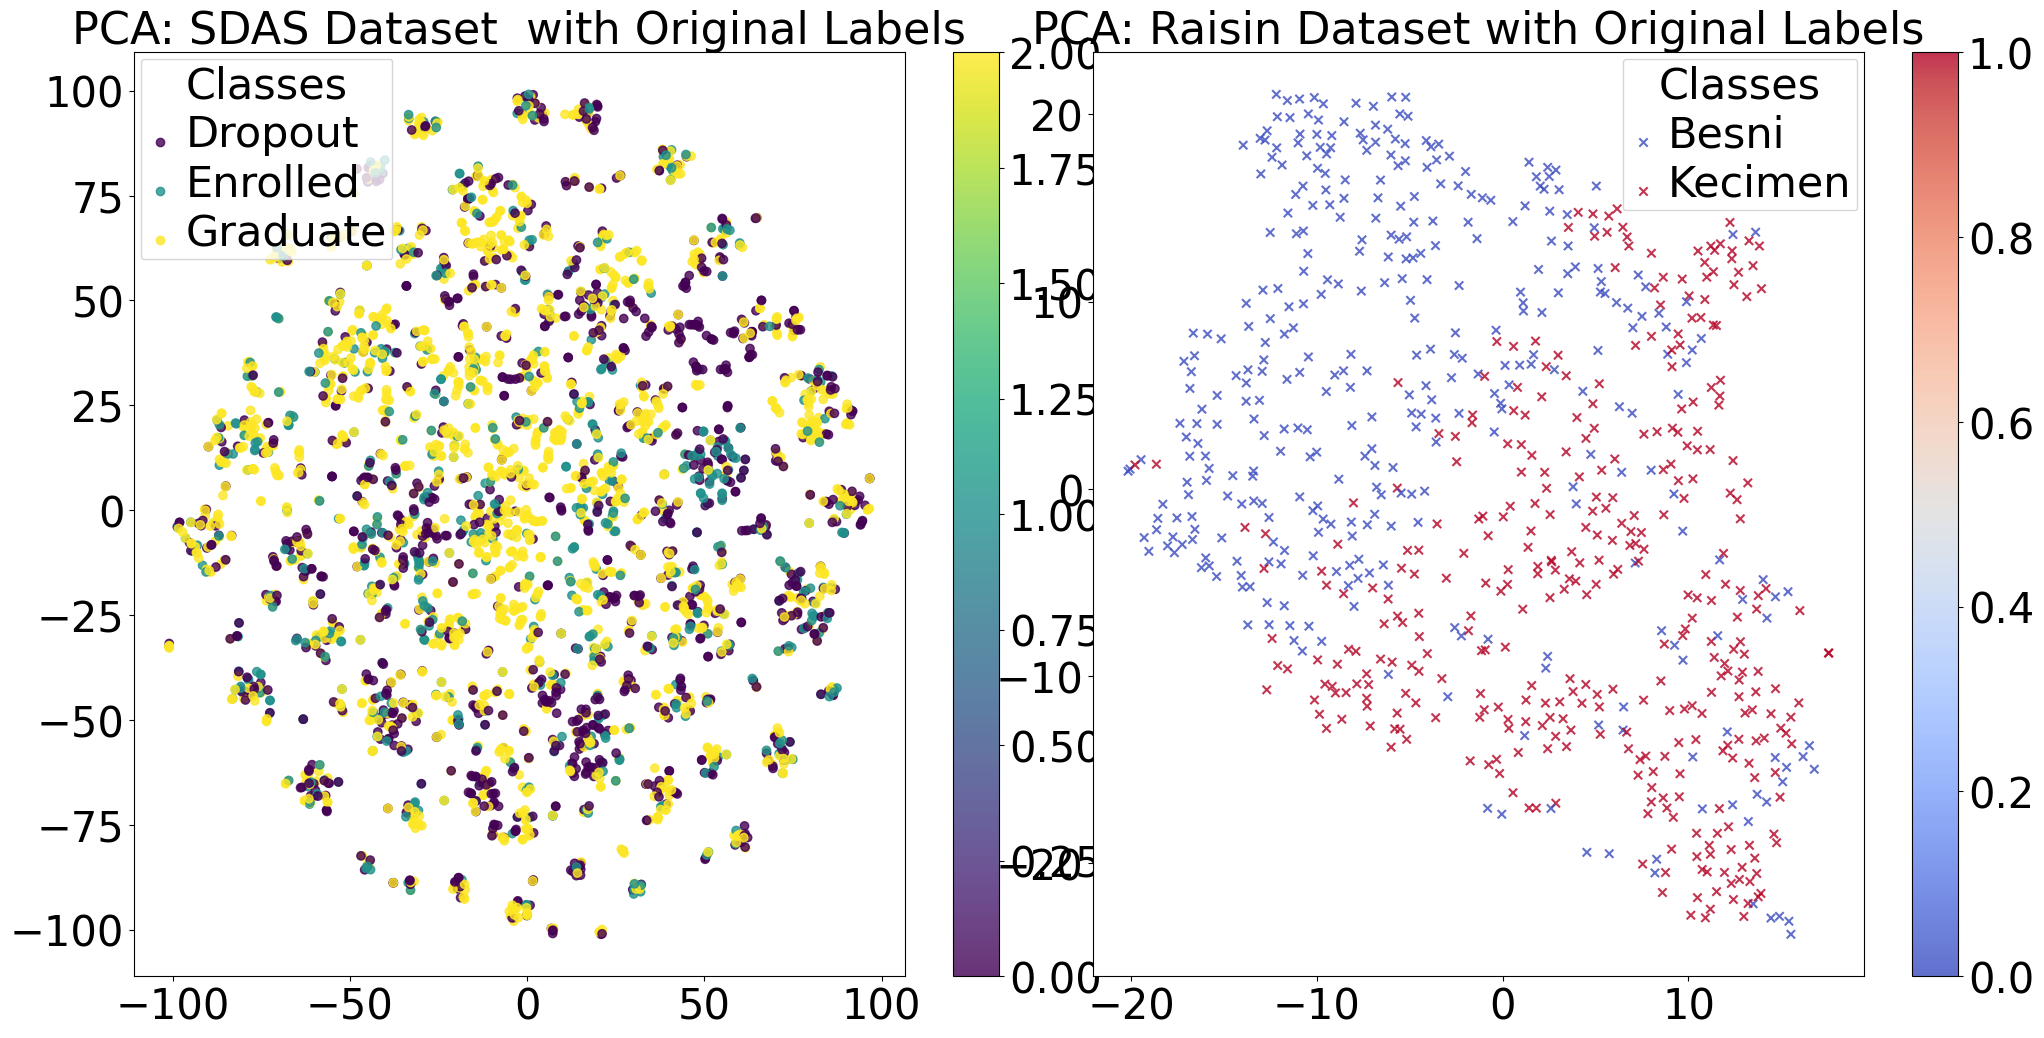

In [171]:
reload_notebook_cell()
# Visualize clusters vs original labels using t-SNE

kwargs_sdas_tsne = {'n_components': 2, 'random_state': 42, 'perplexity': 5}
kwargs_raisin_tsne = {'n_components': 2, 'random_state': 42, 'perplexity': 50}
tsne_sdas = TSNE_pipeline(pca_sdas_comp, list_of_categories=CATEGORY_COLUMNS_UCML, **kwargs_sdas_tsne)
tsne_raisin = TSNE_pipeline(pca_raisin_comp, **kwargs_raisin_tsne)
    
tsne_comps_raisin = tsne_raisin.fit_transform(pca_raisin_comp)
tsne_comps_asds = tsne_sdas.fit_transform(pca_sdas_comp)
    
# Create subplots for visualization
plt.figure(figsize=(20, 10))

# SDAS Dataset
plt.subplot(1, 2, 1)
plt.title("PCA: SDAS Dataset  with Original Labels")
scatter_sdas = plt.scatter(tsne_comps_asds[:, 0], tsne_comps_asds[:, 1], c=y_train_encoded_sdas, cmap='viridis', marker='o', alpha=0.8)
plt.colorbar()
# Create a legend for SDAS dataset
handles_sdas, _ = scatter_sdas.legend_elements()
labels_sdas = [str(i) for i in np.unique(y_train_sdas)]
plt.legend(handles_sdas, labels_sdas, title="Classes")
plt.tight_layout()

# Raisin Dataset
plt.subplot(1, 2, 2)
plt.title("PCA: Raisin Dataset with Original Labels")
scatter_raisin = plt.scatter(tsne_comps_raisin[:, 0], tsne_comps_raisin[:, 1], c=y_train_encode_raisin, cmap='coolwarm', marker='x', alpha=0.8)
plt.colorbar()
# Create a legend for Raisin dataset
handles_raisin, _ = scatter_raisin.legend_elements()
labels_raisin = [str(i) for i in np.unique(y_train_raisin)]
plt.legend(handles_raisin, labels_raisin, title="Classes")

plt.tight_layout()
helpers.increase_font_size_subplots_included(   plt, tick_fontsize=15, constant=2)
plt.show()



## RP + EM

In [172]:
reload_notebook_cell()
best_n_components_rp_sdas = 186
best_n_components_rp_raisin = 5

# Fit PCA for SDAS dataset
rp_sdas_comp = pipelines.GaussianRP_pipeline(X_train_sdas, list_of_categories=CATEGORY_COLUMNS_UCML, n_components=best_n_components_rp_sdas, random_state=42).fit_transform(X_train_sdas)
rp_raisin_comp = pipelines.GaussianRP_pipeline(X_train_raisin, list_of_categories=[], n_components=best_n_components_rp_raisin, random_state=42).fit_transform(X_train_raisin)



Best parameters for SDAS: {'classifier__covariance_type': 'spherical', 'classifier__n_components': 6}
Min BIC score for SDAS: 288354.8369667187
Best parameters for Raisin: {'classifier__covariance_type': 'full', 'classifier__n_components': 3}
Min BIC score for Raisin: 439.52368445331587


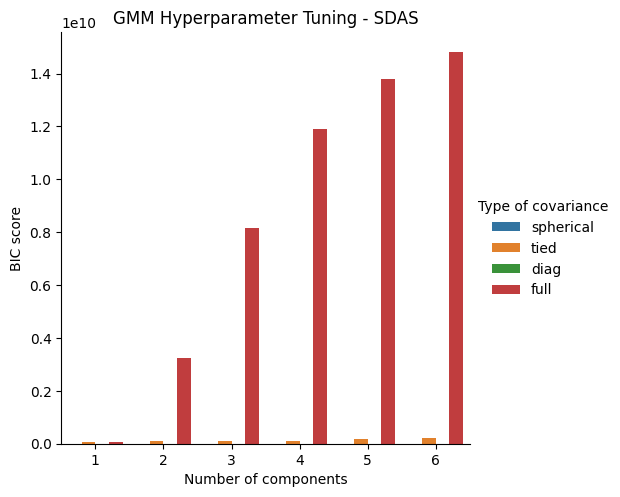

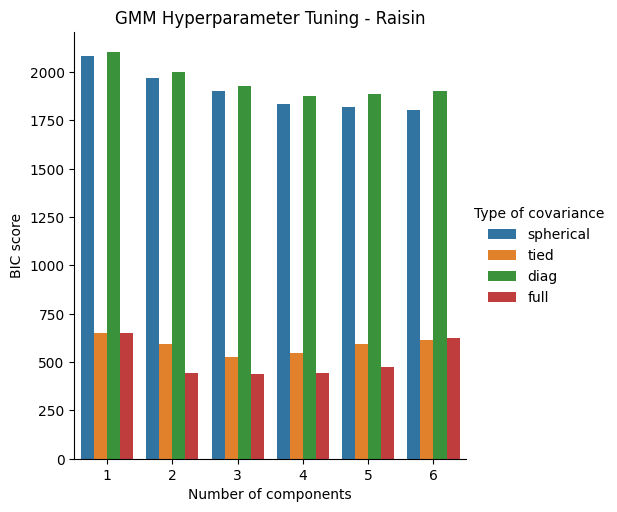

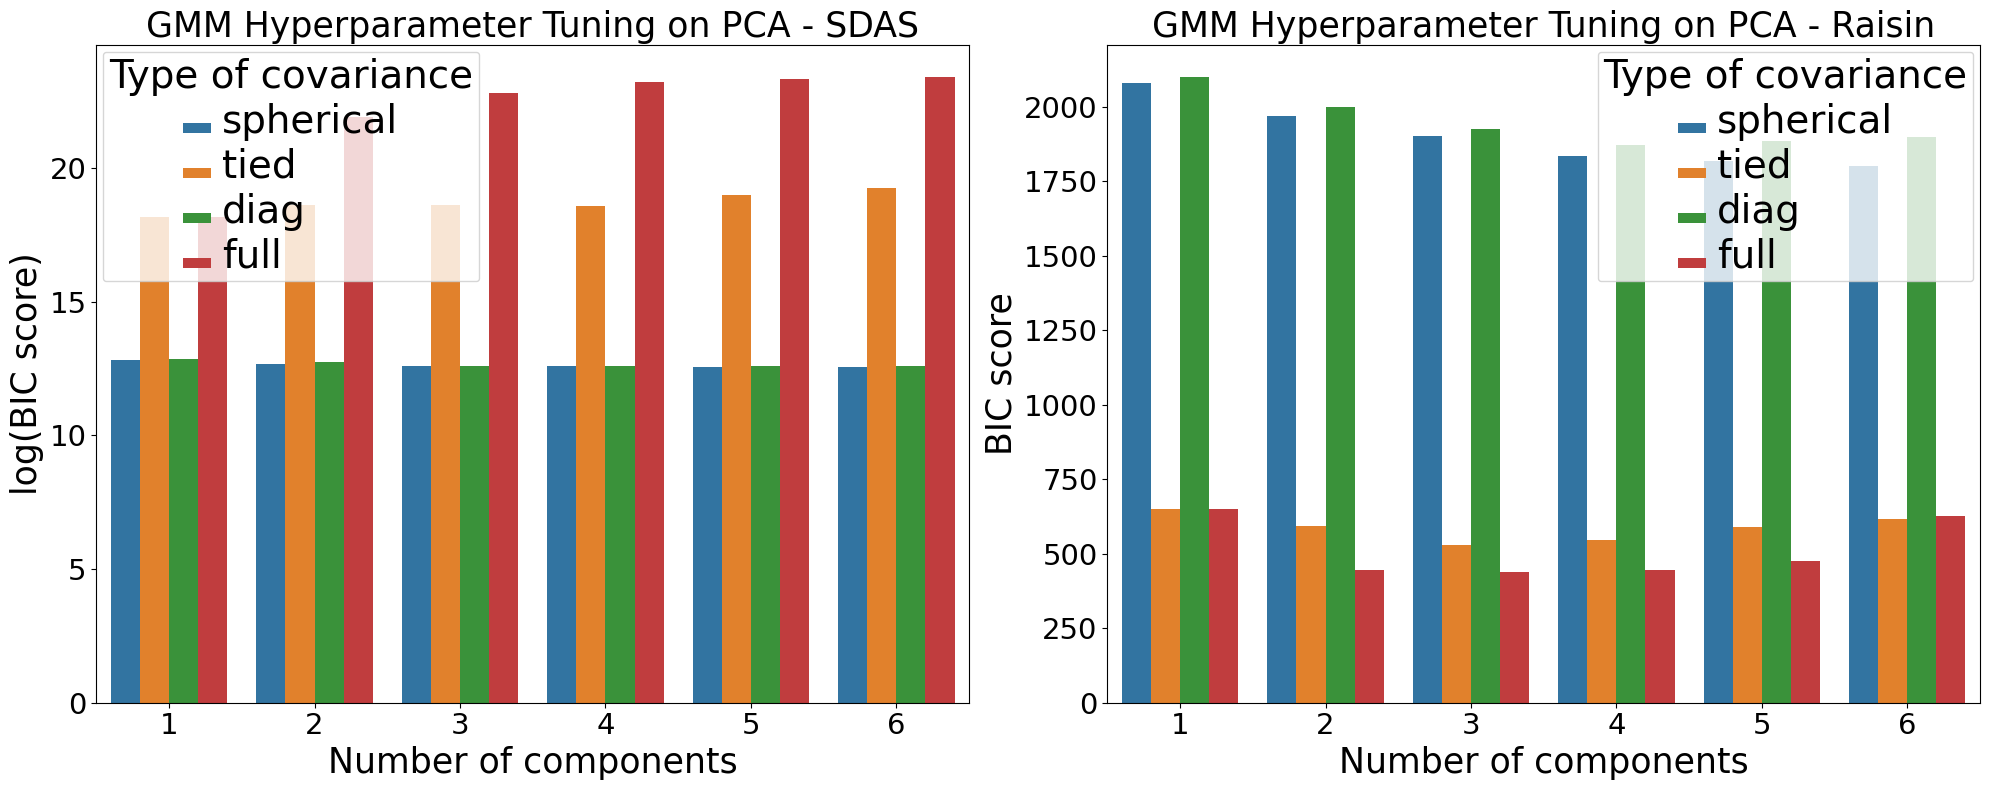

Best parameters for SDAS: {'classifier__covariance_type': 'spherical', 'classifier__n_components': 6}
Min BIC score for SDAS: 288354.8369667187
Best parameters for Raisin: {'classifier__covariance_type': 'full', 'classifier__n_components': 3}
Min BIC score for Raisin: 439.52368445331587


In [173]:
reload_notebook_cell()



# Perform GridSearchCV for both datasets
min_mean_sdas_bic, best_params_sdas, df_sdas = pipeline_helpers.grid_search_gmm(rp_sdas_comp, [], "SDAS")
min_mean_raisin_bic, best_params_raisin, df_raisin = pipeline_helpers.grid_search_gmm(rp_raisin_comp, [], "Raisin")

# Print the best parameters
print(f"Best parameters for SDAS: {best_params_sdas}")
print(f"Min BIC score for SDAS: {min_mean_sdas_bic}")
print(f"Best parameters for Raisin: {best_params_raisin}")
print(f"Min BIC score for Raisin: {min_mean_raisin_bic}")

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

df_sdas["log(BIC score)"] = np.log(df_sdas["BIC score"])
df_raisin["log(BIC score)"] = np.log(df_raisin["BIC score"])

# Plot SDAS results
sns.barplot(
    data=df_sdas,
    x="Number of components",
    y="log(BIC score)", # set scale to log so you can see the differences of spherical better
    hue="Type of covariance",
    ax=axs[0]
).set(title='GMM Hyperparameter Tuning on PCA - SDAS')

# Plot Raisin results
sns.barplot(
    data=df_raisin,
    x="Number of components",
    y="BIC score",
    hue="Type of covariance",
    ax=axs[1]
).set(title='GMM Hyperparameter Tuning on PCA - Raisin')
helpers.increase_font_size(plt)
helpers.increase_font_size_subplots_included(   plt, title_fontsize=14, constant=1.8)
# helpers.increase_font_size(axs[1])

# Adjust layout
plt.tight_layout()
plt.show()

# Print the best parameters and BIC scores
print(f"Best parameters for SDAS: {best_params_sdas}")
print(f"Min BIC score for SDAS: {min_mean_sdas_bic}")
print(f"Best parameters for Raisin: {best_params_raisin}")
print(f"Min BIC score for Raisin: {min_mean_raisin_bic}")

In [174]:
reload_notebook_cell()
# get the labels for the best model
best_gmm_sdas = pipelines.GMM_pipeline(rp_sdas_comp, CATEGORY_COLUMNS_UCML, n_components=best_params_sdas['classifier__n_components'], covariance_type=best_params_sdas['classifier__covariance_type'], random_state=42).fit(rp_sdas_comp)
best_gmm_raisin = pipelines.GMM_pipeline(rp_raisin_comp, [], n_components=best_params_raisin['classifier__n_components'], covariance_type=best_params_raisin['classifier__covariance_type'], random_state=42).fit(rp_raisin_comp)
gmm_labels_sdas_labels = best_gmm_sdas['classifier'].predict(rp_sdas_comp)
gmm_labels_raisin_labels = best_gmm_raisin['classifier'].predict(rp_raisin_comp)

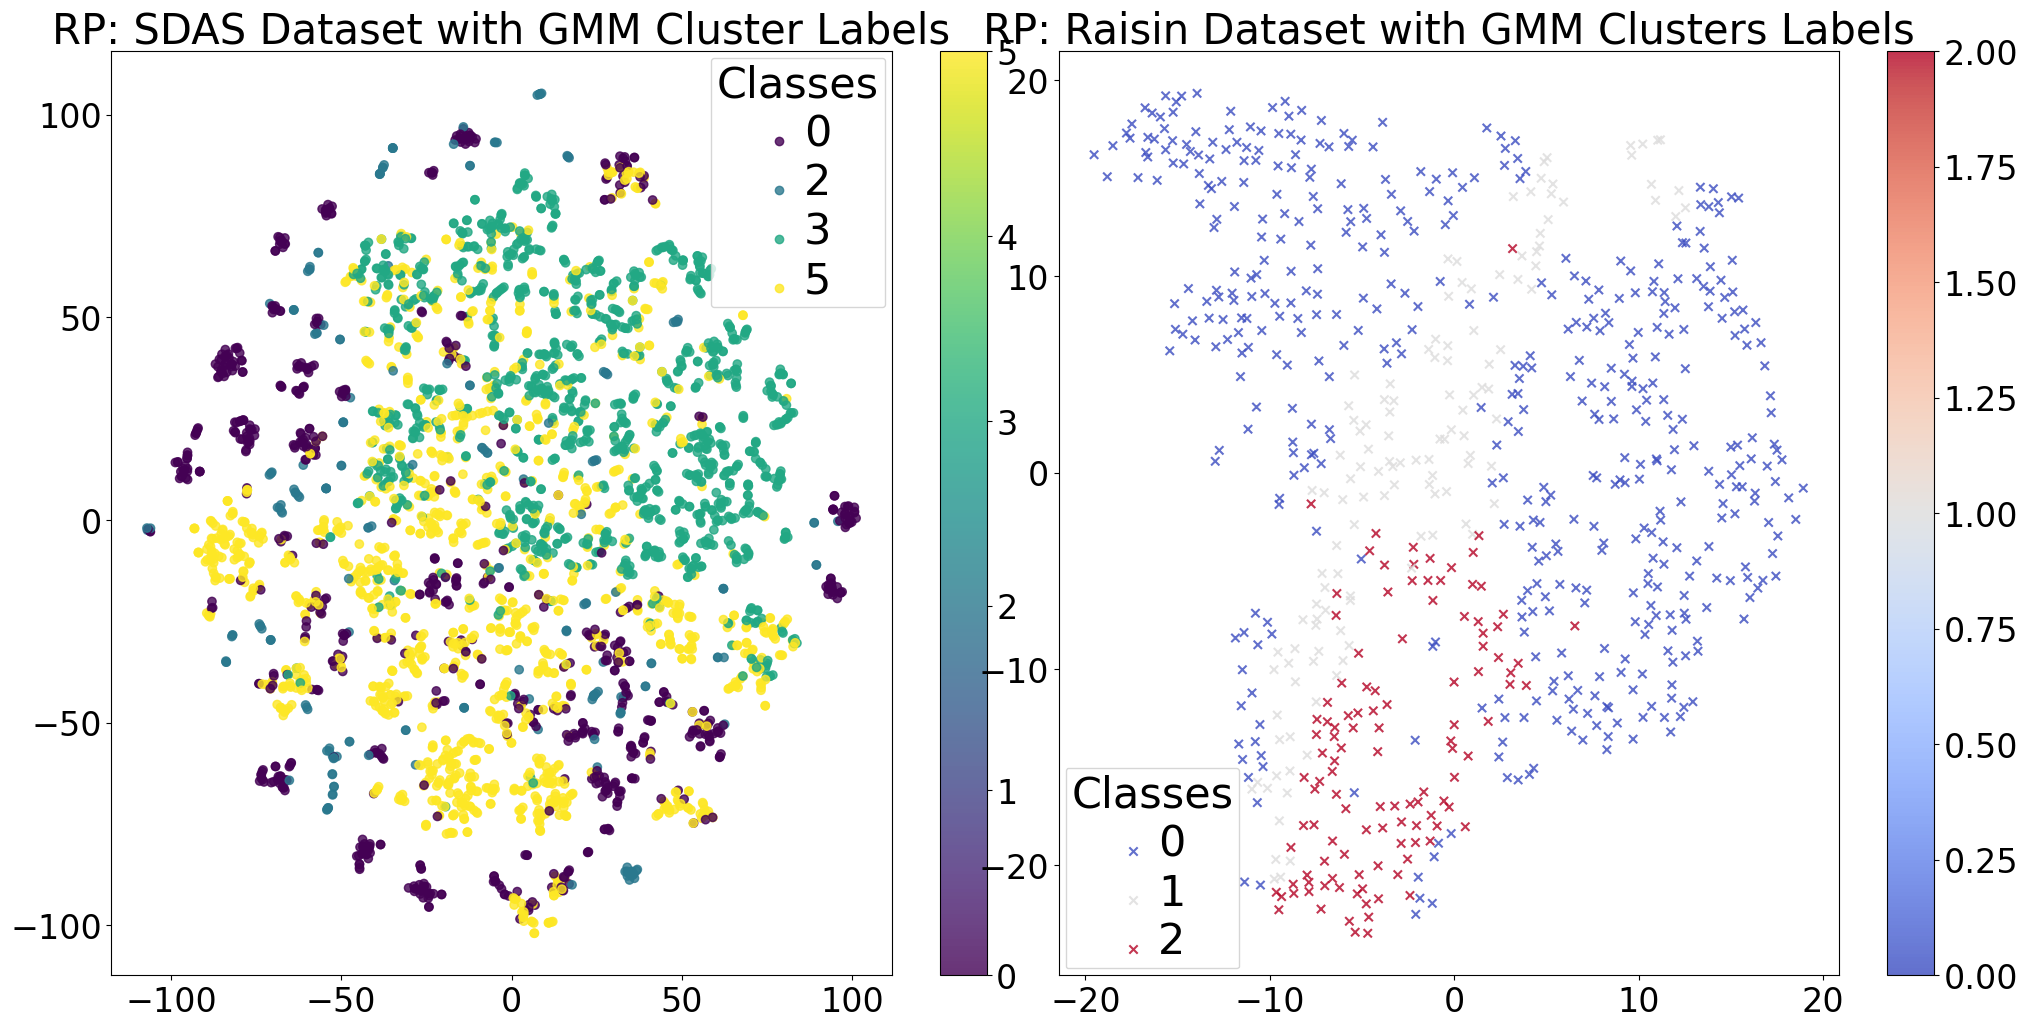

In [175]:
reload_notebook_cell()
# Visualize clusters vs original labels using t-SNE

kwargs_sdas_tsne = {'n_components': 2, 'random_state': 42, 'perplexity': 5}
kwargs_raisin_tsne = {'n_components': 2, 'random_state': 42, 'perplexity': 50}
tsne_sdas = TSNE_pipeline(rp_sdas_comp, list_of_categories=CATEGORY_COLUMNS_UCML, **kwargs_sdas_tsne)
tsne_raisin = TSNE_pipeline(rp_raisin_comp, **kwargs_raisin_tsne)
    
tsne_comps_raisin = tsne_raisin.fit_transform(rp_raisin_comp)
tsne_comps_asds = tsne_sdas.fit_transform(rp_sdas_comp)
    
# Create subplots for visualization
plt.figure(figsize=(20, 10))

# SDAS Dataset
plt.subplot(1, 2, 1)
plt.title("RP: SDAS Dataset with GMM Cluster Labels")
scatter_sdas = plt.scatter(tsne_comps_asds[:, 0], tsne_comps_asds[:, 1], c=gmm_labels_sdas_labels, cmap='viridis', marker='o', alpha=0.8)
plt.colorbar()
# Create a legend for SDAS dataset
handles_sdas, _ = scatter_sdas.legend_elements()
labels_sdas = [str(i) for i in np.unique(gmm_labels_sdas_labels)]
plt.legend(handles_sdas, labels_sdas, title="Classes")
plt.tight_layout()

# Raisin Dataset
plt.subplot(1, 2, 2)
plt.title("RP: Raisin Dataset with GMM Clusters Labels")
scatter_raisin = plt.scatter(tsne_comps_raisin[:, 0], tsne_comps_raisin[:, 1], c=gmm_labels_raisin_labels, cmap='coolwarm', marker='x', alpha=0.8)
plt.colorbar()
# Create a legend for Raisin dataset
handles_raisin, _ = scatter_raisin.legend_elements()
labels_raisin = [str(i) for i in np.unique(gmm_labels_raisin_labels)]
plt.legend(handles_raisin, labels_raisin, title="Classes")

plt.tight_layout()
helpers.increase_font_size_subplots_included(   plt, title_fontsize=15, constant=2)

plt.show()

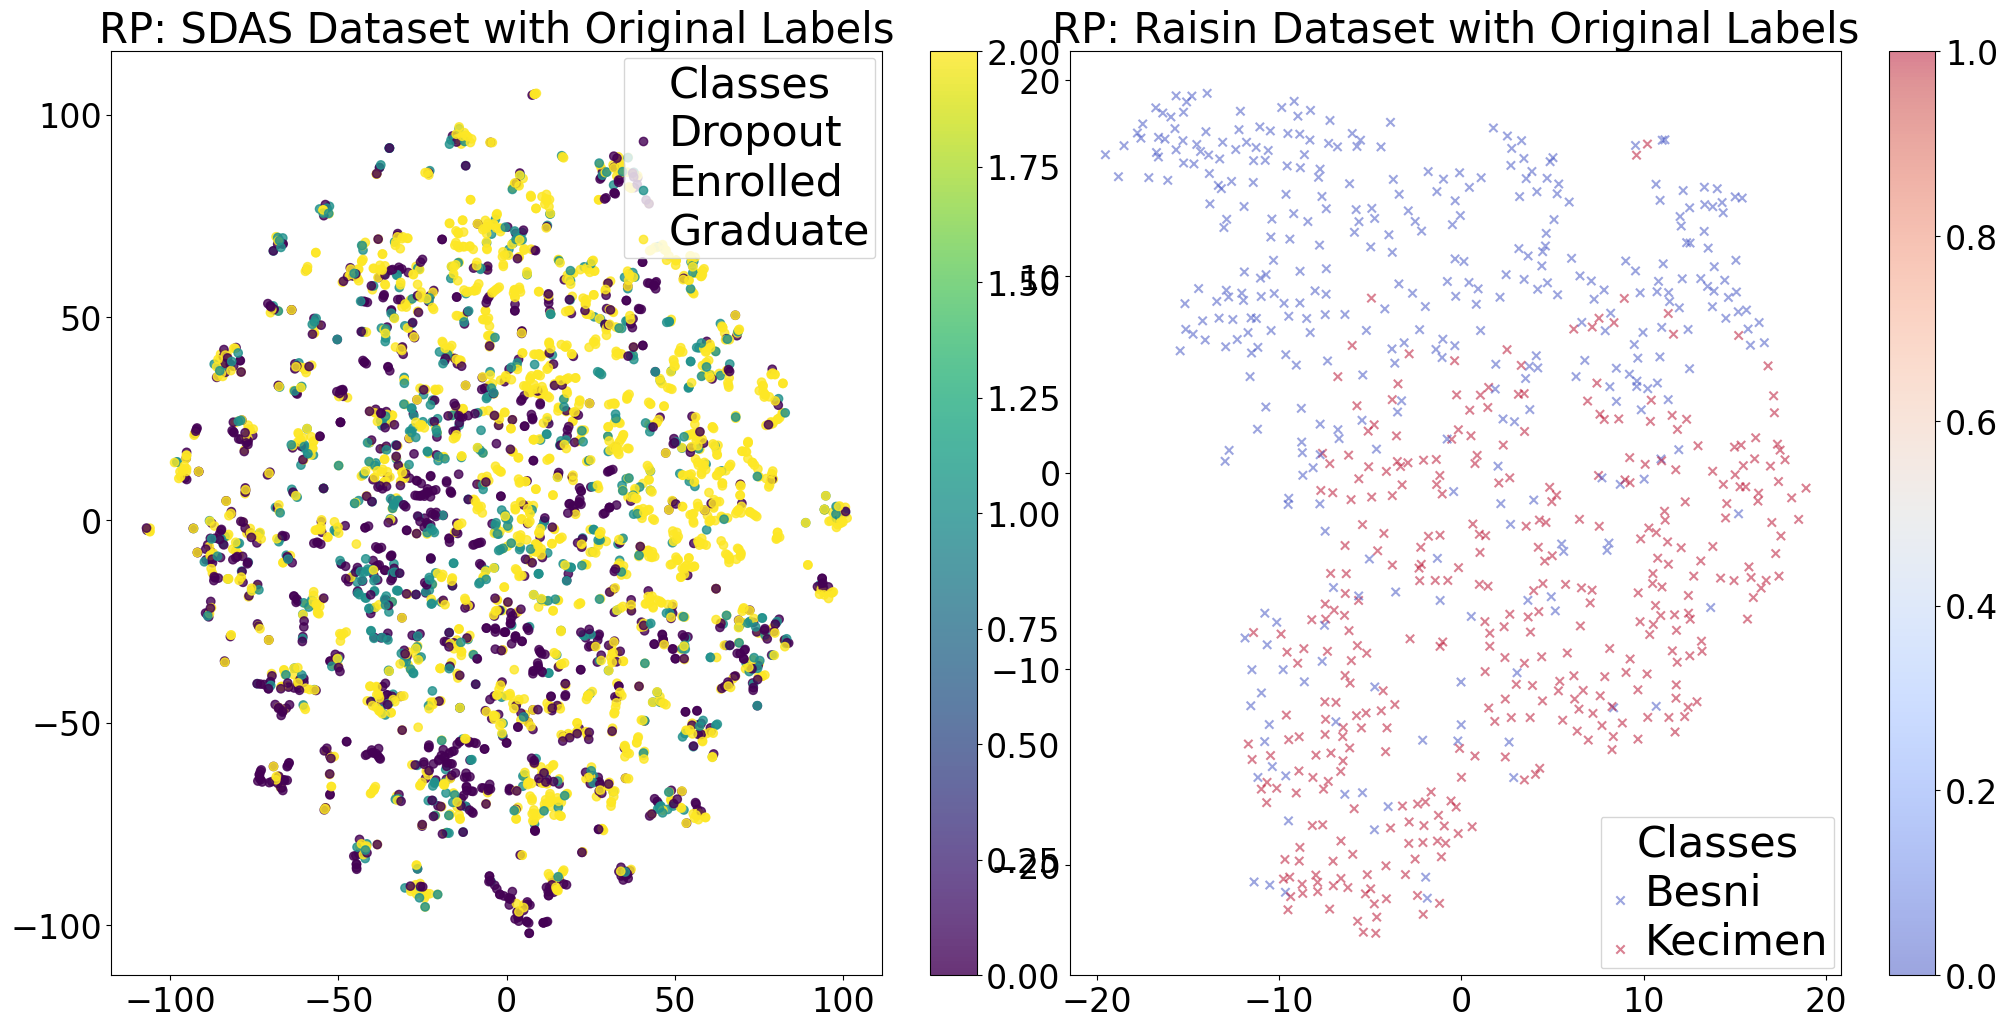

In [176]:
reload_notebook_cell()
# Visualize clusters vs original labels using t-SNE

kwargs_sdas_tsne = {'n_components': 2, 'random_state': 42, 'perplexity': 5}
kwargs_raisin_tsne = {'n_components': 2, 'random_state': 42, 'perplexity': 50}
tsne_sdas = TSNE_pipeline(rp_sdas_comp, list_of_categories=CATEGORY_COLUMNS_UCML, **kwargs_sdas_tsne)
tsne_raisin = TSNE_pipeline(rp_raisin_comp, **kwargs_raisin_tsne)
    
tsne_comps_raisin = tsne_raisin.fit_transform(rp_raisin_comp)
tsne_comps_asds = tsne_sdas.fit_transform( rp_sdas_comp)
    
# Create subplots for visualization
plt.figure(figsize=(20, 10))

# SDAS Dataset
plt.subplot(1, 2, 1)
plt.title("RP: SDAS Dataset with Original Labels")
scatter_sdas = plt.scatter(tsne_comps_asds[:, 0], tsne_comps_asds[:, 1], c=y_train_encoded_sdas, cmap='viridis', marker='o', alpha=0.8)
plt.colorbar()
# Create a legend for SDAS dataset
handles_sdas, _ = scatter_sdas.legend_elements()
labels_sdas = [str(i) for i in np.unique(y_train_sdas)]
plt.legend(handles_sdas, labels_sdas, title="Classes")
plt.tight_layout()

# Raisin Dataset
plt.subplot(1, 2, 2)
plt.title("RP: Raisin Dataset with Original Labels")
scatter_raisin = plt.scatter(tsne_comps_raisin[:, 0], tsne_comps_raisin[:, 1], c=y_train_encode_raisin, cmap='coolwarm', marker='x', alpha=0.5)
plt.colorbar()
# Create a legend for Raisin dataset
handles_raisin, _ = scatter_raisin.legend_elements()
labels_raisin = [str(i) for i in np.unique(y_train_raisin)]
plt.legend(handles_raisin, labels_raisin, title="Classes")

plt.tight_layout()
helpers.increase_font_size_subplots_included(   plt, title_fontsize=15, constant=2)
plt.show()


## ICA + EM

In [177]:
reload_notebook_cell()

best_n_components_ica_sdas = 6
best_n_components_ica_raisin = 2

# Fit PCA for SDAS dataset
ica_sdas_comp = pipelines.ICA_pipeline(X_train_sdas, list_of_categories=CATEGORY_COLUMNS_UCML, n_components=best_n_components_ica_sdas, whiten='unit-variance', random_state=42).fit_transform(X_train_sdas)
ica_raisin_comp = pipelines.ICA_pipeline(X_train_raisin, list_of_categories=[], n_components=best_n_components_ica_raisin, whiten='unit-variance', random_state=42).fit_transform(X_train_raisin)

Best parameters for SDAS: {'classifier__covariance_type': 'full', 'classifier__n_components': 6}
Min BIC score for SDAS: 898.4339998202656
Best parameters for Raisin: {'classifier__covariance_type': 'diag', 'classifier__n_components': 3}
Min BIC score for Raisin: 571.0538582096322


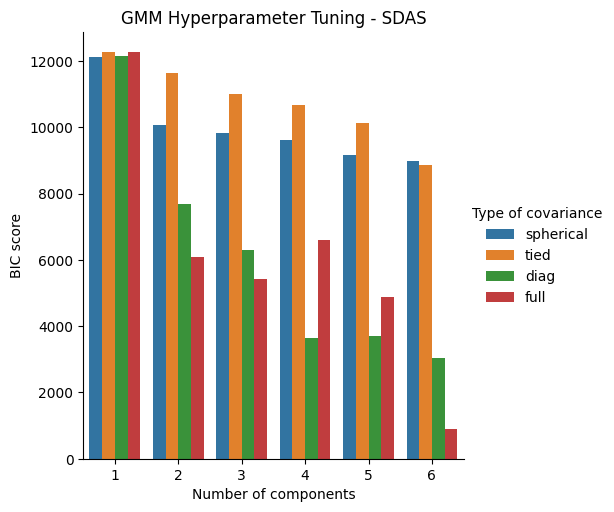

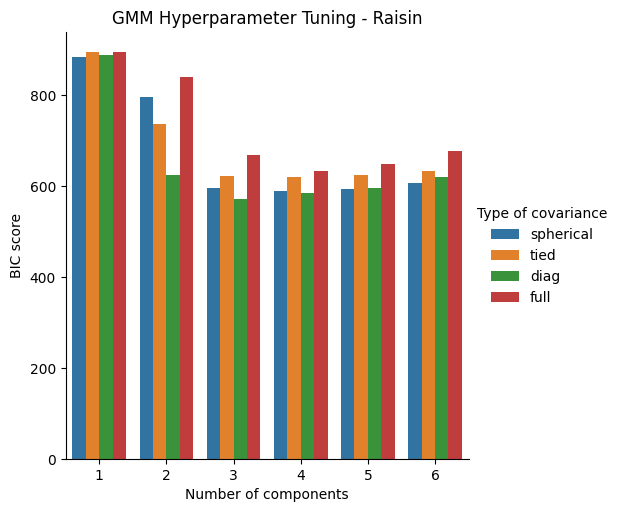

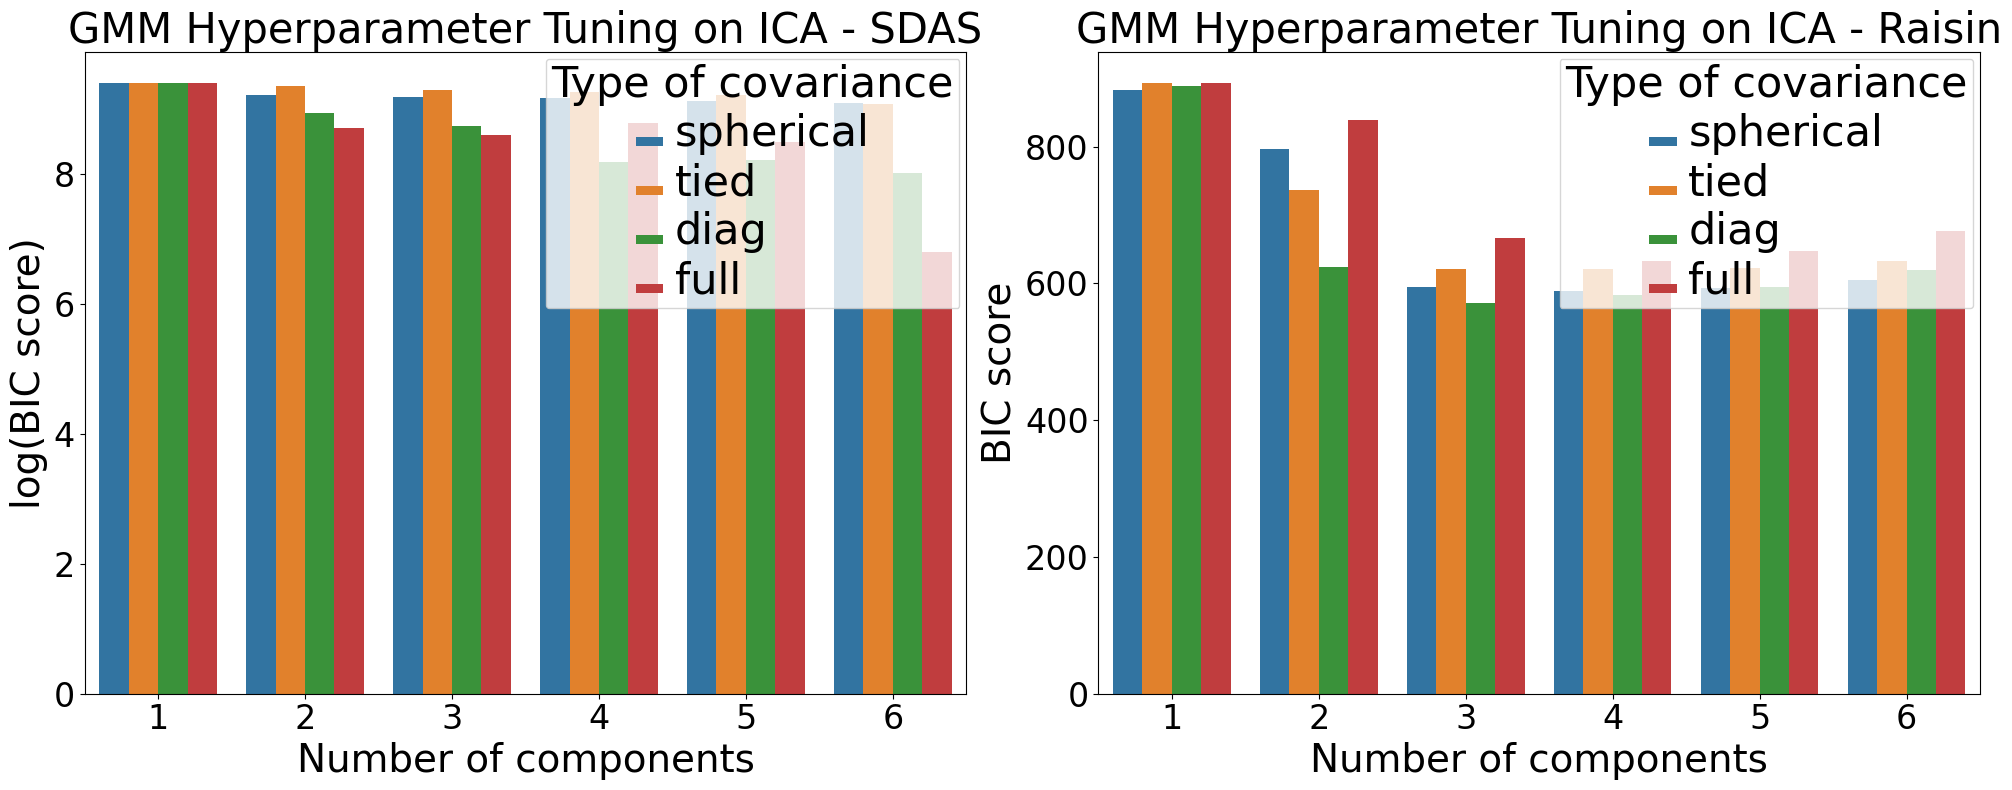

Best parameters for SDAS: {'classifier__covariance_type': 'full', 'classifier__n_components': 6}
Min BIC score for SDAS: 898.4339998202656
Best parameters for Raisin: {'classifier__covariance_type': 'diag', 'classifier__n_components': 3}
Min BIC score for Raisin: 571.0538582096322


In [178]:
reload_notebook_cell()



# Perform GridSearchCV for both datasets
min_mean_sdas_bic, best_params_sdas, df_sdas = pipeline_helpers.grid_search_gmm(ica_sdas_comp, [], "SDAS")
min_mean_raisin_bic, best_params_raisin, df_raisin = pipeline_helpers.grid_search_gmm(ica_raisin_comp, [], "Raisin")

# Print the best parameters
print(f"Best parameters for SDAS: {best_params_sdas}")
print(f"Min BIC score for SDAS: {min_mean_sdas_bic}")
print(f"Best parameters for Raisin: {best_params_raisin}")
print(f"Min BIC score for Raisin: {min_mean_raisin_bic}")

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

df_sdas["log(BIC score)"] = np.log(df_sdas["BIC score"])
df_raisin["log(BIC score)"] = np.log(df_raisin["BIC score"])

# Plot SDAS results
sns.barplot(
    data=df_sdas,
    x="Number of components",
    y="log(BIC score)", # set scale to log so you can see the differences of spherical better
    hue="Type of covariance",
    ax=axs[0]
).set(title='GMM Hyperparameter Tuning on ICA - SDAS')

# Plot Raisin results
sns.barplot(
    data=df_raisin,
    x="Number of components",
    y="BIC score",
    hue="Type of covariance",
    ax=axs[1]
).set(title='GMM Hyperparameter Tuning on ICA - Raisin')
helpers.increase_font_size(plt)
helpers.increase_font_size_subplots_included(plt, title_fontsize=15, constant=2)
# helpers.increase_font_size(axs[1])

# Adjust layout
plt.tight_layout()
plt.show()

# Print the best parameters and BIC scores
print(f"Best parameters for SDAS: {best_params_sdas}")
print(f"Min BIC score for SDAS: {min_mean_sdas_bic}")
print(f"Best parameters for Raisin: {best_params_raisin}")
print(f"Min BIC score for Raisin: {min_mean_raisin_bic}")

In [179]:
# get the labels for the best model
best_gmm_sdas = pipelines.GMM_pipeline(ica_sdas_comp, CATEGORY_COLUMNS_UCML, n_components=best_params_sdas['classifier__n_components'], covariance_type=best_params_sdas['classifier__covariance_type'], random_state=42).fit(ica_sdas_comp)
best_gmm_raisin = pipelines.GMM_pipeline(ica_raisin_comp, [], n_components=best_params_raisin['classifier__n_components'], covariance_type=best_params_raisin['classifier__covariance_type'], random_state=42).fit(ica_raisin_comp)
gmm_labels_sdas_labels = best_gmm_sdas['classifier'].predict(ica_sdas_comp)
gmm_labels_raisin_labels = best_gmm_raisin['classifier'].predict(ica_raisin_comp)

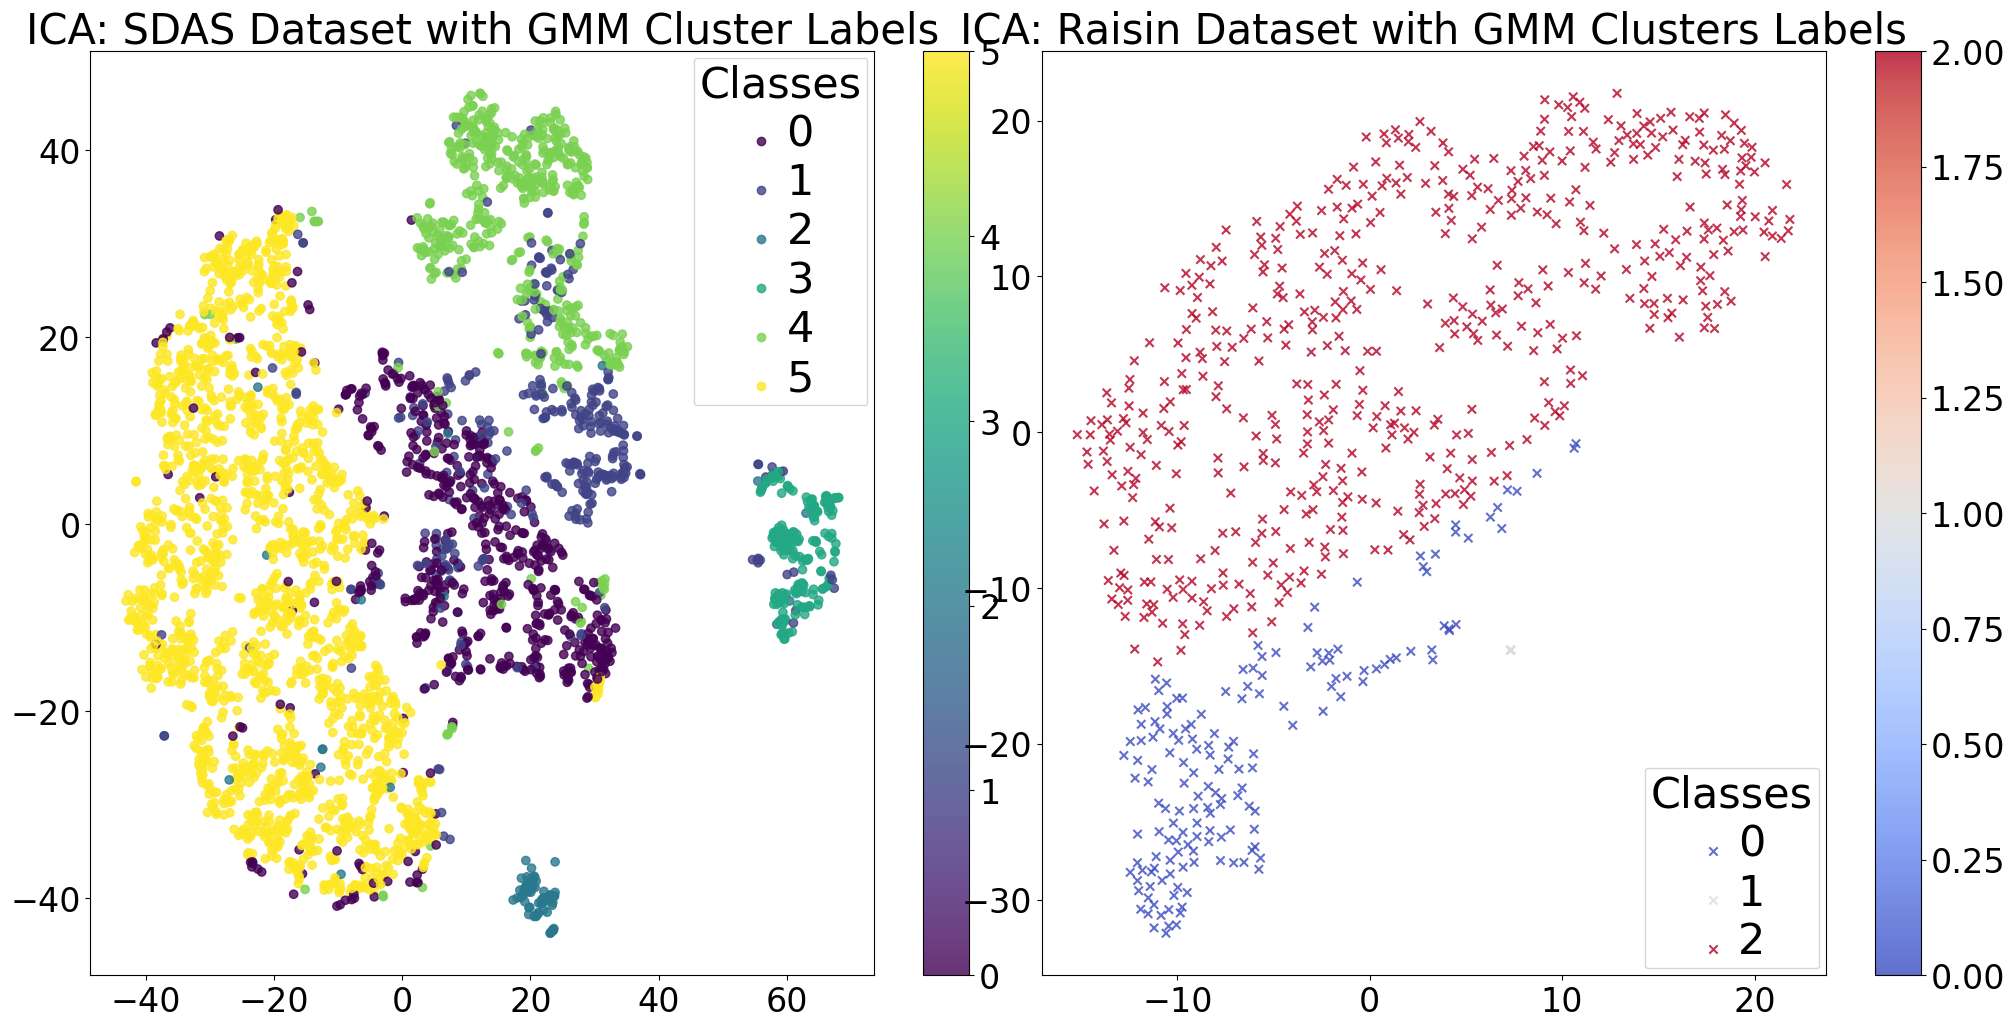

In [180]:
reload_notebook_cell()
# Visualize clusters vs original labels using t-SNE

kwargs_sdas_tsne = {'n_components': 2, 'random_state': 42, 'perplexity': 50}
kwargs_raisin_tsne = {'n_components': 2, 'random_state': 42, 'perplexity': 50}
tsne_sdas = TSNE_pipeline(ica_sdas_comp, list_of_categories=CATEGORY_COLUMNS_UCML, **kwargs_sdas_tsne)
tsne_raisin = TSNE_pipeline(ica_raisin_comp, **kwargs_raisin_tsne)
    
tsne_comps_raisin = tsne_raisin.fit_transform(ica_raisin_comp)
tsne_comps_asds = tsne_sdas.fit_transform(ica_sdas_comp)
    
# Create subplots for visualization
plt.figure(figsize=(20, 10))

# SDAS Dataset
plt.subplot(1, 2, 1)
plt.title("ICA: SDAS Dataset with GMM Cluster Labels")
scatter_sdas = plt.scatter(tsne_comps_asds[:, 0], tsne_comps_asds[:, 1], c=gmm_labels_sdas_labels, cmap='viridis', marker='o', alpha=0.8)
plt.colorbar()
# Create a legend for SDAS dataset
handles_sdas, _ = scatter_sdas.legend_elements()
labels_sdas = [str(i) for i in np.unique(gmm_labels_sdas_labels)]
plt.legend(handles_sdas, labels_sdas, title="Classes")
plt.tight_layout()

# Raisin Dataset
plt.subplot(1, 2, 2)
plt.title("ICA: Raisin Dataset with GMM Clusters Labels")
scatter_raisin = plt.scatter(tsne_comps_raisin[:, 0], tsne_comps_raisin[:, 1], c=gmm_labels_raisin_labels, cmap='coolwarm', marker='x', alpha=0.8)
plt.colorbar()
# Create a legend for Raisin dataset
handles_raisin, _ = scatter_raisin.legend_elements()
labels_raisin = [str(i) for i in np.unique(gmm_labels_raisin_labels)]
plt.legend(handles_raisin, labels_raisin, title="Classes")

plt.tight_layout()
helpers.increase_font_size_subplots_included(   plt, title_fontsize=15, constant=2)
 
plt.show()

In [181]:
import pandas as pd
reload_notebook_cell()

# Create a mapping from encoded labels to original labels
label_mapping_sdas = {i: label for i, label in enumerate(y_train_sdas['Target'].unique())}
label_mapping_raisin = {i: label for i, label in enumerate(y_train_raisin['Class'].unique())}

cluster_label_counts_table = pipeline_helpers.cluster_label_counts(y_train_sdas['Target'], gmm_labels_sdas_labels, label_mapping_sdas)

# display cluster labels
cluster_labels_sdas = pd.DataFrame({"cluster_labels": gmm_labels_sdas_labels})

cluster_labels_sdas

cluster_labels_sdas["cluster_labels"] = cluster_labels_sdas["cluster_labels"].apply(lambda x: "Graduate" if x else "Enrolled")


# Calculate precision and recall
precision_recall_df = pipeline_helpers.calculate_precision_recall(y_train_sdas, cluster_labels_sdas["cluster_labels"], label_mapping_sdas)
print(precision_recall_df)

# Map cluster labels to the original labels
cluster_labels_sdas = pd.DataFrame({"cluster_labels": kmeans_ica_labels_sdas})
cluster_labels_sdas["cluster_labels"] = cluster_labels_sdas["cluster_labels"].apply(lambda x: "Dropout" if x else "Graduate")
precision_recall_df = pipeline_helpers.calculate_precision_recall(y_train_sdas, cluster_labels_sdas["cluster_labels"], label_mapping_sdas)
print(precision_recall_df, "print not able to distinguish what label should belong to what class ")
cluster_label_counts_table

      Class  Precision    Recall
0   Dropout   0.000000  0.000000
1  Enrolled   0.243902  0.233281
2  Graduate   0.511970  0.835846
      Class  Precision    Recall
0   Dropout   0.157873  0.343891
1  Enrolled   0.000000  0.000000
2  Graduate   0.206714  0.130653 print not able to distinguish what label should belong to what class 


c:\Users\WarrenKushner\miniconda3\envs\MLA2\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\WarrenKushner\miniconda3\envs\MLA2\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\WarrenKushner\miniconda3\envs\MLA2\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\WarrenKushner\miniconda3\envs\MLA2\lib\site-packages\sklearn\metrics\_classi

True Labels     Dropout  Enrolled  Graduate
Cluster Labels                             
0                   171       150       294
1                   221        25       107
2                    25        18        44
3                    56        46       107
4                   410        56        59
5                   222       348      1180

In [182]:
reload_notebook_cell()

cluster_label_counts_table = pipeline_helpers.cluster_label_counts(y_train_raisin['Class'], gmm_labels_raisin_labels, label_mapping_raisin)

# display cluster labels
cluster_labels_raisin = pd.DataFrame({"cluster_labels": gmm_labels_raisin_labels})

cluster_labels_raisin["cluster_labels"] = cluster_labels_raisin["cluster_labels"].apply(lambda x: "Besni" if x in [0,3] else "Kecimen")


# Calculate precision and recall
precision_recall_df = pipeline_helpers.calculate_precision_recall(y_train_raisin, cluster_labels_raisin["cluster_labels"], label_mapping_raisin)
print(precision_recall_df)
cluster_label_counts_table

     Class  Precision    Recall
0    Besni   0.993827  0.442308
1  Kecimen   0.636201  0.997191


c:\Users\WarrenKushner\miniconda3\envs\MLA2\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


True Labels     Besni  Kecimen
Cluster Labels                
0                 161        1
1                   3        2
2                 200      353

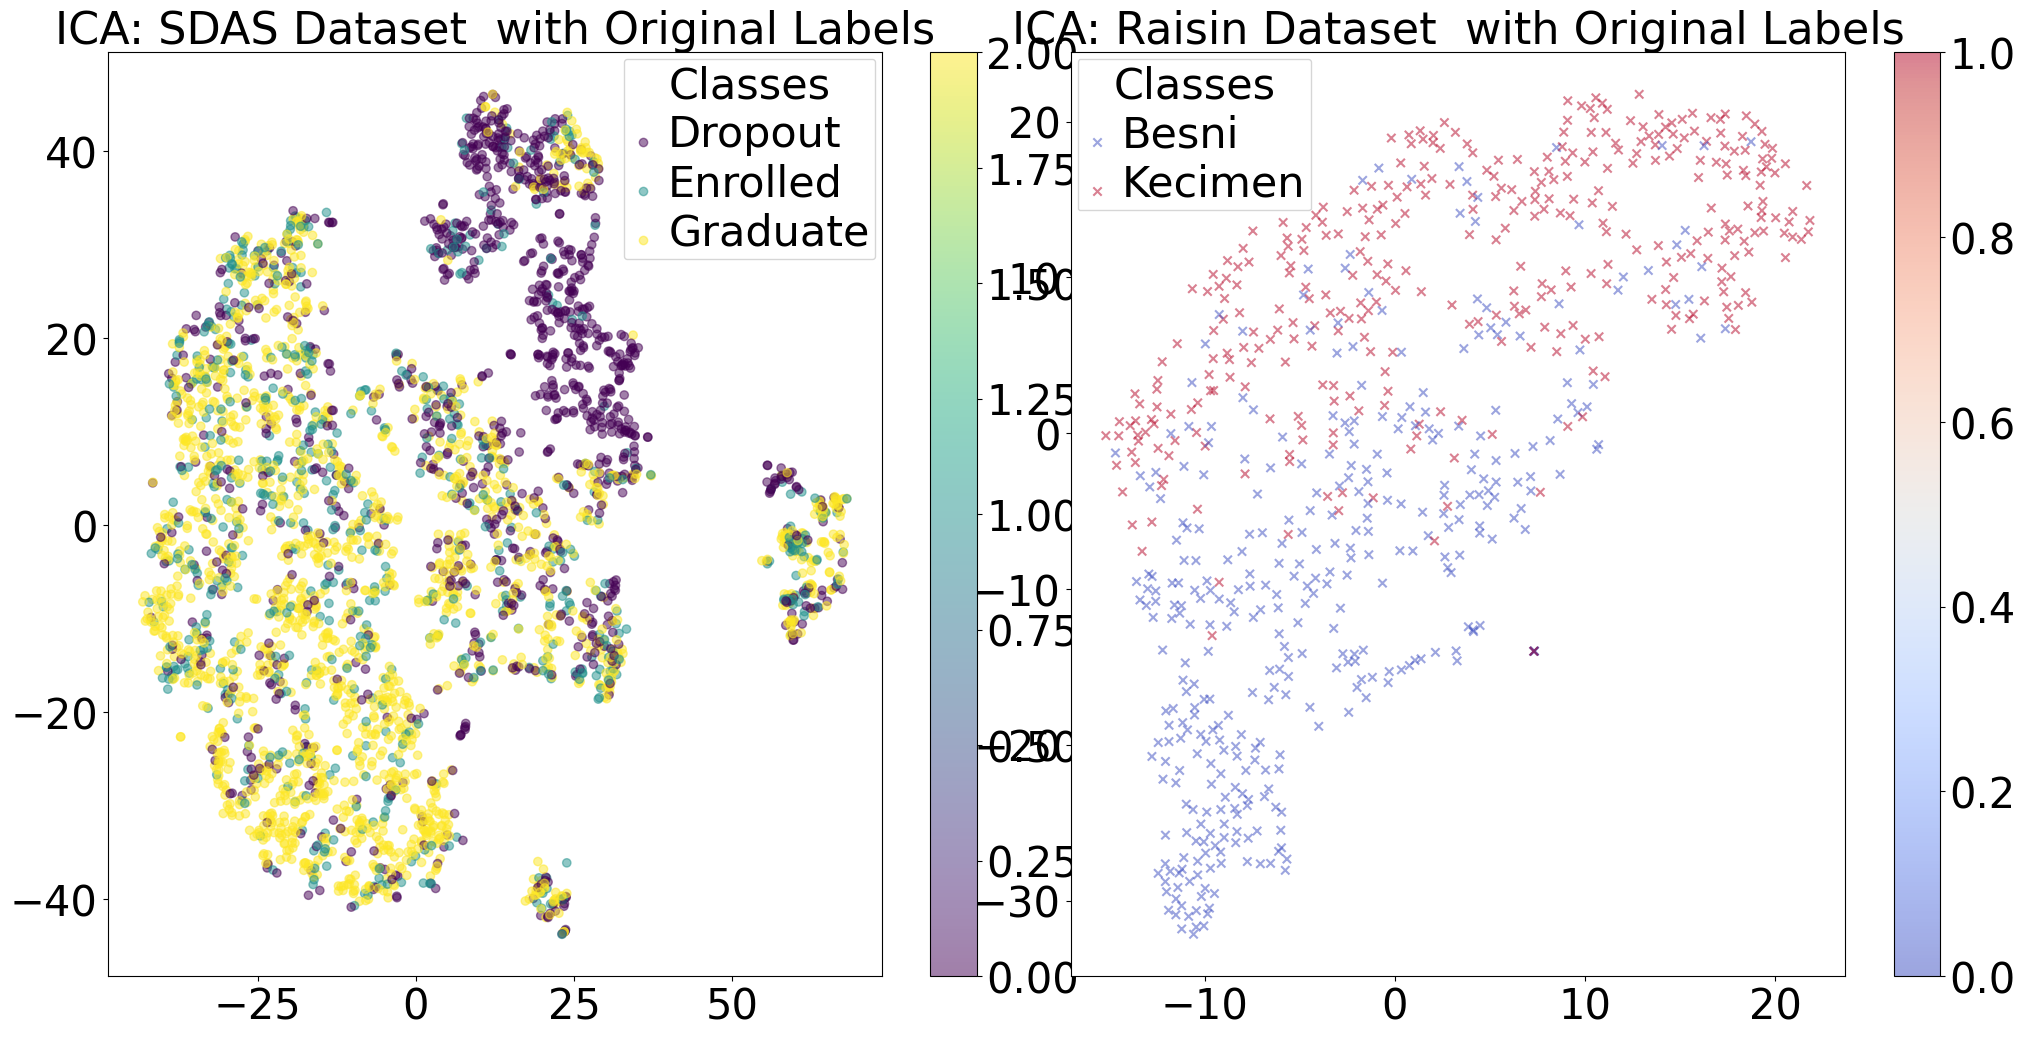

In [183]:
reload_notebook_cell()
# Visualize clusters vs original labels using t-SNE

kwargs_sdas_tsne = {'n_components': 2, 'random_state': 42, 'perplexity': 50}
kwargs_raisin_tsne = {'n_components': 2, 'random_state': 42, 'perplexity': 50}
tsne_sdas = TSNE_pipeline(ica_sdas_comp, list_of_categories=CATEGORY_COLUMNS_UCML, **kwargs_sdas_tsne)
tsne_raisin = TSNE_pipeline(ica_raisin_comp, **kwargs_raisin_tsne)
    
tsne_comps_raisin = tsne_raisin.fit_transform(ica_raisin_comp)
tsne_comps_asds = tsne_sdas.fit_transform( ica_sdas_comp)
    
# Create subplots for visualization
plt.figure(figsize=(20, 10))

# SDAS Dataset
plt.subplot(1, 2, 1)
plt.title("ICA: SDAS Dataset  with Original Labels")
scatter_sdas = plt.scatter(tsne_comps_asds[:, 0], tsne_comps_asds[:, 1], c=y_train_encoded_sdas, cmap='viridis', marker='o', alpha=0.5)
plt.colorbar()
# Create a legend for SDAS dataset
handles_sdas, _ = scatter_sdas.legend_elements()
labels_sdas = [str(i) for i in np.unique(y_train_sdas)]
plt.legend(handles_sdas, labels_sdas, title="Classes")
plt.tight_layout()

# Raisin Dataset
plt.subplot(1, 2, 2)
plt.title("ICA: Raisin Dataset  with Original Labels")
scatter_raisin = plt.scatter(tsne_comps_raisin[:, 0], tsne_comps_raisin[:, 1], c=y_train_encode_raisin, cmap='coolwarm', marker='x', alpha=0.5)
plt.colorbar()
# Create a legend for Raisin dataset
handles_raisin, _ = scatter_raisin.legend_elements()
labels_raisin = [str(i) for i in np.unique(y_train_raisin)]
plt.legend(handles_raisin, labels_raisin, title="Classes")

plt.tight_layout()
helpers.increase_font_size_subplots_included(   plt, tick_fontsize=15, constant=2)
plt.show()
